Statistical Hacking for Economists, part 2
==========================================

**Author:** Jan Boone




# Table of Contents







## Introduction



This is the second part of the Statistical Hacking for Economists notebook. In this part we look at the following topics. We start by creating our own dataset by getting it directly from the [Eurostat website](https://ec.europa.eu/eurostat/data/database) into the notebook. Then we use `pandas` to get the data into the shape that we want and merge it with data on other variables.

We use this data to estimate a Bayesian model that is equivalent to an OLS regression using `pymc3`. We explain what the advantages are of using a Bayesian analysis and give a short introduction to Bayesian statistics. Since we have data on more than 20 countries, it is hard to distinguish the different countries in a graph. We explain how you can create an interactive (html) plot using `altair`.

One of the advantages of Bayesian statistics is a consistent way to deal with missing data which is better than both deleting observations with missing values and interpolating missing values. We explain how missing values can be coded using `pymc3`.

Then we consider modeling timeseries using `pymc3` by using a Gaussian Process.

A Bayesian estimation of a neural network allows us to get a better idea of what the uncertainties are surrounding the weights and predictions of the neural network.

We finish by simulating 95% confidence intervals to explain what they are and what they are not.



## Preamble



Import the relevant libraries.



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from scipy import optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import pymc3 as pm
import arviz as az
import seaborn as sn
import theano

import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat

from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Dealing with data



In this section we work with the API of Eurostat to get data directly into the notebook.

We look at the data for each variable, decide on the shape we want to have for the dataframe and then merge a number of data sets together. For this we will be using pandas. Further, we use the python file `country_codes.py` which should be in the same folder as this notebook.



### Countries



We focus on the following countries when looking at the data. For the Eurostat data this does not matter so much. But if you want to combine Eurostat data with OECD data, this selection can be useful.



In [2]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

### Mortality



The [Eurostat website](https://ec.europa.eu/eurostat/data/database?node_code=hlth_cd_apr) has a browser where you can look for data. Here we are looking for data on mortality. You can click on the link to the data browser to see the [details of the variable](https://ec.europa.eu/eurostat/databrowser/view/hlth_cd_apr/default/table?lang=en). At the top-left of the screen you can see the name of the variable in the line &ldquo;`online data code: HLTH_CD_APR`&rdquo;. The name of this variable we use below in the `get_data_df` method.

So we call this method and collect the information in the dataframe `df`. Then we check what `df` looks like:



In [8]:
df = eurostat.get_data_df('hlth_cd_apr')
df.head()

,freq,mortalit,sex,icd10,unit,geo\TIME_PERIOD,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,A,PRVT,F,A00-A09,NR,AT,7.0,12.0,9.0,6.0,5.0,15.0,10.0,8.0,6.0,13.0
1,A,PRVT,F,A00-A09,NR,BE,25.0,11.0,20.0,26.0,26.0,27.0,45.0,26.0,44.0,39.0
2,A,PRVT,F,A00-A09,NR,BG,5.0,4.0,10.0,11.0,13.0,7.0,4.0,3.0,4.0,5.0
3,A,PRVT,F,A00-A09,NR,CH,14.0,14.0,9.0,9.0,5.0,13.0,13.0,11.0,14.0,10.0
4,A,PRVT,F,A00-A09,NR,CY,6.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0


So we have a number of columns with abbreviations in them and then we have data for the years 2011-2017. Use the website of the variable to figure out what the abbreviations mean. To illustrate, the column `mortalit` gives three measures of mortality:



In [9]:
df.mortalit.unique()

array(['PRVT', 'TOTAL', 'TRT'], dtype=object)

We will be interested in preventable &rsquo;PRVT&rsquo; and treatable &rsquo;TRT&rsquo; mortality.

First, let&rsquo;s change the country column &rsquo;geo\time&rsquo; and use country names instead of abbreviations. We need to &ldquo;escape&rdquo; the &rsquo;\\&rsquo; symbol to make sure pandas reads &rsquo;\\&rsquo; literally (not as a symbol). That is why we have &rsquo;\\\\&rsquo; in the code below. We use the `eurostat_dictionary` to turn the country abbreviations into country names.

Note that to change the column name we use `.rename`; to change values in a row, we use `.replace`. The replacements are provided using a python dictionary: `{'old_name':'new_name'}`.

If you are wondering why we use `inplace=True`, just run the code block without this to see the difference.



In [10]:
df.rename({'geo\\TIME_PERIOD':'geo'},inplace=True,axis=1)
df['country'] = df['geo'].replace(eurostat_dictionary)
df.head()

,freq,mortalit,sex,icd10,unit,geo,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,country
0,A,PRVT,F,A00-A09,NR,AT,7.0,12.0,9.0,6.0,5.0,15.0,10.0,8.0,6.0,13.0,Austria
1,A,PRVT,F,A00-A09,NR,BE,25.0,11.0,20.0,26.0,26.0,27.0,45.0,26.0,44.0,39.0,Belgium
2,A,PRVT,F,A00-A09,NR,BG,5.0,4.0,10.0,11.0,13.0,7.0,4.0,3.0,4.0,5.0,Bulgaria
3,A,PRVT,F,A00-A09,NR,CH,14.0,14.0,9.0,9.0,5.0,13.0,13.0,11.0,14.0,10.0,Switzerland
4,A,PRVT,F,A00-A09,NR,CY,6.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,Cyprus


Now we will select the values that we are interested in: only EU countries, both males and females, both preventable and treatable mortality, unit of measurement rate &rsquo;RT&rsquo; (not number &rsquo;NR&rsquo;) and all diseases (e.g. not the subset &ldquo; [A00-A09] Intestinal infectious diseases&rdquo;).

For selection, we can use `==` or `.isin()`. With numbers we can also use smaller/greater than `<,>` etc.

After this selection, we can drop some columns to make the dataframe a bit easier to handle.



In [11]:
df = df[df.country.isin(EU_countries) & (df.sex.isin(["M","F"]) ) & (df.mortalit.isin(["PRVT","TRT"])) \
        & (df.unit == "RT") & (df.icd10 == "TOTAL")]
df.drop(["unit","icd10","geo"],axis=1,inplace=True)
df.head()

,freq,mortalit,sex,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,country
6300,A,PRVT,F,95.29,96.16,93.22,93.95,97.52,96.39,92.94,93.14,94.81,99.09,Austria
6301,A,PRVT,F,101.35,99.97,100.34,95.40,99.71,94.13,93.42,92.83,92.39,113.63,Belgium
6302,A,PRVT,F,119.32,126.17,119.29,129.04,128.32,120.14,121.87,119.05,120.05,177.73,Bulgaria
6303,A,PRVT,F,73.75,74.02,73.85,72.70,69.37,68.91,68.45,71.15,67.12,72.59,Switzerland
6304,A,PRVT,F,57.31,49.38,47.75,54.65,55.67,49.98,46.69,50.87,49.03,54.90,Cyprus


Now we want to &ldquo;move&rdquo; the years into rows and the two values for `mortalit` we want to have in columns. That is, we want to get the data into the following shape:

| country|year|sex|Preventable  mortality|Treatable  mortality|
|---|---|---|---|---|
| Austria|2011|F|95.29|67.41|
| Austria|2011|M|248.50|96.86|
| Austria|2012|F|96.16|69.72|
| Austria|2012|M|252.28|91.45|
| Austria|2013|F|93.22|66.84|

We do this in steps. Pandas&rsquo; [melt method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) helps us to get the years in a column `year` and the mortality rates in a column `rate`. The columns 2011-2017 (`np.arange(2011,2018)` in the code) become row values in the column `year`. This column `year` together with the identifier variables uniquely identifies a row. The values for PRVT and TRT are given in the column `rate`.



In [12]:
df = pd.melt(df,id_vars=['country','sex','mortalit'],
                        value_vars=["{}".format(year) for year in np.arange(2011,2018)],
                        var_name='year',
                        value_name='rate')
df.head()

,country,sex,mortalit,year,rate
0,Austria,F,PRVT,2011,95.29
1,Belgium,F,PRVT,2011,101.35
2,Bulgaria,F,PRVT,2011,119.32
3,Switzerland,F,PRVT,2011,73.75
4,Cyprus,F,PRVT,2011,57.31


Instead of one column `rate` we want to have two columns (i.e. two variables); one corresponds to PRVT, the other to TRT. For this we use [unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html). We put the identifying columns in an order such that the last column refers to `mortalit` which contains the two values PRVT and TRT. These columns become the index of the dataframe. Then we unstack the dataframe on the last column of the index, which is the default value of `unstack()`. This pivots the column `mortalit` into two separate columns PRVT and TRT.



In [13]:
df.set_index(['country','year','sex','mortalit'],inplace=True)
df = df.unstack()
df.head()

rate       
mortalit            PRVT    TRT
country year sex               
Austria 2011 F     95.29  67.41
             M    248.50  96.86
        2012 F     96.16  69.72
             M    252.28  91.45
        2013 F     93.22  66.84

Finally, we reset the index (such that it no longer features the hierarchy &#x2013;with &rsquo;rate&rsquo; and &rsquo;mortalit&rsquo;&#x2013; shown above) and rename the columns to make them easier to read/understand.



In [14]:
df.reset_index(inplace=True)
df.columns = [' '.join(col).strip() for col in df.columns.values]
df.rename({'rate PRVT':'Preventable mortality', 'rate TRT':'Treatable mortality'},inplace=True,axis=1)
df.head()

,country,year,sex,Preventable mortality,Treatable mortality
0,Austria,2011,F,95.29,67.41
1,Austria,2011,M,248.50,96.86
2,Austria,2012,F,96.16,69.72
3,Austria,2012,M,252.28,91.45
4,Austria,2013,F,93.22,66.84


Now we consider a number of other variables. There you can practice the steps above to get these dataframes into the right shape. Finally, we merge each dataframe with the one previously created.



### GDP per capita



Go to this [page](https://ec.europa.eu/eurostat/data/database?node_code=nama_10_pc) to find the variable name for &ldquo;Main GDP aggregates per capita&rdquo;; fill in the &ldquo;dots&rdquo; in the following code:



In [15]:
df_n = eurostat.get_data_df('nama_10_pc')
df_n.head()

,freq,unit,na_item,geo\TIME_PERIOD,1975,1976,1977,1978,1979,1980,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,A,CLV10_EUR_HAB,B1GQ,AL,NaN,NaN,NaN,NaN,NaN,NaN,...,3330.0,3410.0,3530.0,3670.0,3830.0,3920.0,3810.0,NaN,NaN,NaN
1,A,CLV10_EUR_HAB,B1GQ,AT,NaN,NaN,NaN,NaN,NaN,NaN,...,36130.0,36140.0,36390.0,36980.0,37690.0,38070.0,35390.0,36740.0,38080.0,37430.0
2,A,CLV10_EUR_HAB,B1GQ,BE,NaN,NaN,NaN,NaN,NaN,NaN,...,33870.0,34360.0,34620.0,35050.0,35510.0,36110.0,34060.0,36250.0,37040.0,37260.0
3,A,CLV10_EUR_HAB,B1GQ,BG,NaN,NaN,NaN,NaN,NaN,NaN,...,5470.0,5700.0,5910.0,6120.0,6330.0,6630.0,6400.0,6950.0,7680.0,7850.0
4,A,CLV10_EUR_HAB,B1GQ,CH,NaN,NaN,NaN,NaN,NaN,NaN,...,59300.0,59600.0,60170.0,60420.0,61690.0,61950.0,60190.0,62950.0,64030.0,63490.0


#### Question: copy/paste from the code above to get a table of the format below.



#### Table



| |unit|na<sub>item</sub>|geo|2020|2019|2018|2017|2016|
|---|---|---|---|---|---|---|---|---|
| 0|CLV10<sub>EUR</sub><sub>HAB</sub>|B1GQ|AT|35490.0|38170.0|37800.0|37030.0|36390.0|
| 1|CLV10<sub>EUR</sub><sub>HAB</sub>|B1GQ|BE|33500.0|35940.0|35510.0|35040.0|34620.0|
| 2|CLV10<sub>EUR</sub><sub>HAB</sub>|B1GQ|BG|6600.0|6840.0|6550.0|6310.0|6050.0|
| 3|CLV10<sub>EUR</sub><sub>HAB</sub>|B1GQ|CH|60500.0|62780.0|62550.0|61170.0|60780.0|
| 4|CLV10<sub>EUR</sub><sub>HAB</sub>|B1GQ|CY|23050.0|24530.0|24120.0|23200.0|22270.0|

and

| |2015|2014|2013|2012|2011|country|
|---|---|---|---|---|---|---|
| 0|36140.0|36130.0|36180.0|36390.0|36300.0|Austria|
| 1|34360.0|33870.0|33490.0|33490.0|33460.0|Belgium|
| 2|5790.0|5530.0|5400.0|5350.0|5300.0|Bulgaria|
| 3|60220.0|59920.0|59200.0|58820.0|58730.0|Switzerland|
| 4|21020.0|20250.0|20400.0|21780.0|22900.0|Cyprus|

The table actually continues for more years. Since most of our variables only start from 2011, we use the statement `df_n.drop(np.arange(1975,2011),axis=1,inplace=True)` to only focus on the years 2011-2020.



In [16]:
df_n = df_n.drop(
    ["{}".format(year) for year in np.arange(1975,2011)],
    axis = 1
).drop(
    "freq",
    axis = 1
).rename(
    {"geo\\TIME_PERIOD": "geo"},
    axis = 1,
)

In [17]:
df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

In [18]:
df_n = df_n[df_n.country.isin(EU_countries)]
df_n.head()

,unit,na_item,geo,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,country
1,CLV10_EUR_HAB,B1GQ,AT,36300.0,36390.0,36180.0,36130.0,36140.0,36390.0,36980.0,37690.0,38070.0,35390.0,36740.0,38080.0,37430.0,Austria
2,CLV10_EUR_HAB,B1GQ,BE,33460.0,33490.0,33490.0,33870.0,34360.0,34620.0,35050.0,35510.0,36110.0,34060.0,36250.0,37040.0,37260.0,Belgium
3,CLV10_EUR_HAB,B1GQ,BG,5320.0,5390.0,5390.0,5470.0,5700.0,5910.0,6120.0,6330.0,6630.0,6400.0,6950.0,7680.0,7850.0,Bulgaria
4,CLV10_EUR_HAB,B1GQ,CH,58220.0,58290.0,58650.0,59300.0,59600.0,60170.0,60420.0,61690.0,61950.0,60190.0,62950.0,64030.0,63490.0,Switzerland
5,CLV10_EUR_HAB,B1GQ,CY,22970.0,21840.0,20450.0,20310.0,21120.0,22410.0,23470.0,24500.0,25510.0,24350.0,26520.0,27480.0,27720.0,Cyprus


#### Question: make the following selections:



-   from the column `country` select EU countries
-   from `na_item` select &rsquo;B1GQ&rsquo;
-   from `unit` select &rsquo;CP<sub>EUR</sub><sub>HAB</sub>&rsquo;
-   then drop the columns `unit, na_item, geo`



In [19]:
df_n = df_n[
    (df_n.na_item == 'B1GQ') &\
    (df_n.unit == 'CP_EUR_HAB')
]
df_n.drop(
    [
        "unit", "na_item", "geo"
    ],
    axis= 1,
    inplace = True
)
df_n.head()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,country
1521,36970.0,37820.0,38210.0,38990.0,39890.0,40920.0,42000.0,43590.0,44740.0,42720.0,45270.0,49400.0,52250.0,Austria
1522,34060.0,34770.0,35210.0,35950.0,36960.0,37960.0,39130.0,40260.0,41660.0,39930.0,43840.0,47440.0,49540.0,Belgium
1523,5640.0,5780.0,5790.0,5960.0,6380.0,6840.0,7420.0,8000.0,8820.0,8880.0,10330.0,13270.0,14580.0,Bulgaria
1524,65190.0,66780.0,65730.0,66920.0,75530.0,74260.0,72860.0,72150.0,75150.0,75330.0,78990.0,88620.0,91780.0,Switzerland
1525,23340.0,22570.0,20930.0,20510.0,21170.0,22330.0,23630.0,24910.0,26280.0,24760.0,27690.0,30430.0,32100.0,Cyprus


#### The melt statement



The melt statement is easier now. Together with `year`, a column is uniquely identified by `country` only. Since we only have one variable here (GDP), we do not need to `unstack`.



In [20]:
df_n = pd.melt(df_n,id_vars=['country'],
                        value_vars= ["{}".format(year) for year in np.arange(2011,2021)],
                        var_name='year',value_name='GDP per capita')
df_n.head()

,country,year,GDP per capita
0,Austria,2011,36970.0
1,Belgium,2011,34060.0
2,Bulgaria,2011,5640.0
3,Switzerland,2011,65190.0
4,Cyprus,2011,23340.0


#### merge into dataframe



The final step is to [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) the GDP data with the dataframe `df` on mortality. Since GDP does not vary with gender, the merge is done on the columns `country` and `year`.



In [21]:
df=df.merge(df_n,how='left',left_on=['country','year'], right_on=['country','year'])
df.head()

,country,year,sex,Preventable mortality,Treatable mortality,GDP per capita
0,Austria,2011,F,95.29,67.41,36970.0
1,Austria,2011,M,248.50,96.86,36970.0
2,Austria,2012,F,96.16,69.72,37820.0
3,Austria,2012,M,252.28,91.45,37820.0
4,Austria,2013,F,93.22,66.84,38210.0


We add a couple of other variables with the same procedure:

-   get the data from Eurostat into a new dataframe `df_n`
-   get `df_n` into the correct shape
-   merge `df_n` with the dataframe `df` above

When we finish, all variables are in the dataframe `df` which we then save in a folder `./data`.



### Income quantiles



Use [this page](https://ec.europa.eu/eurostat/databrowser/view/icw_res_02/default/table?lang=en) to get the variable name for &ldquo;Mean and median economic resources of households by income, consumption and wealth quantiles - experimental statistics&rdquo;.



#### Question: complete the variable name in the following code.



We drop the year 2010 as it does not lie in the period for which we have the other data that we download.



In [63]:
df_n = eurostat.get_data_df('icw_res_02')
df_n.rename({'geo\\TIME_PERIOD':'geo'},inplace=True,axis=1)
df_n = df_n[(df_n.indic_il=='INC_DISP')&(df_n.statinfo=='AVG')&(df_n.quant_inc.isin(['QU1', 'QU2', 'QU3', 'QU4', 'QU5']))&(df_n.quant_expn=='TOTAL')&(df_n.quant_wlth=='TOTAL') &\
            (df_n.unit == "EUR")]
df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo','2010', '2020'],axis=1,inplace=True)

In [64]:
df_n.head()

,freq,quant_inc,geo,2015
52401,A,QU1,AT,16542.1
52402,A,QU1,BE,15834.1
52403,A,QU1,BG,1847.7
52404,A,QU1,CY,11467.4
52405,A,QU1,CZ,5855.1


Check what your dataframe looks like now and use the Eurostat website to understand the selections we made above.



#### melt



The melt statement is going to be different now since we only use one year.

The identifier variables are `geo` and `quant_inc`. The value variable is only `[2015]`. For value name you can use &rsquo;y\_&rsquo; to get `y_QU1` to `y_QU5` later as column names for income quintiles.



In [65]:
df_n = df_n.melt(
    id_vars = ["geo", "quant_inc"],
    value_vars = ["2015"],
    var_name = "year",
    value_name = "y_"
)
df_n.head()

,geo,quant_inc,year,y_
0,AT,QU1,2015,16542.1
1,BE,QU1,2015,15834.1
2,BG,QU1,2015,1847.7
3,CY,QU1,2015,11467.4
4,CZ,QU1,2015,5855.1


#### Table



This should give you a dataframe of the form:

| geo|quant<sub>inc</sub>|year|y_|
|---|---|---|---|
| AT|QU1|2015|16497.2|
| BE|QU1|2015|15759.0|
| BG|QU1|2015|1847.7|
| CY|QU1|2015|11467.4|
| CZ|QU1|2015|5855.1|



#### Question: set the index to `['country','year','quant_inc']`; unstack; reset the index; give new column names and rename the country abbreviations to country names.



In [66]:
df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
df_n.drop(
    ['geo'],
    axis = 1,
    inplace = True
)

df_n.set_index(
    ["country", "year", "quant_inc"],
    inplace = True
)
df_n = df_n.unstack()
df_n.reset_index(inplace = True)
df_n.columns = [''.join(col).strip() for col in df_n.columns.values]
df_n.head()

country  year       y_                                    
quant_inc                      QU1      QU2      QU3      QU4      QU5
0           Austria  2015  16542.1  27955.8  36687.8  48214.5  74519.8
1           Belgium  2015  15834.1  23310.6  33248.2  44849.9  68233.2
2          Bulgaria  2015   1847.7   3270.1   5115.9   7451.6  14354.6
3           Croatia  2015   3333.2   6707.4   9936.8  13733.3  21342.7
4            Cyprus  2015  11467.4  18180.6  25357.4  35763.9  60673.0

#### Table



This should give you a dataframe of the form:

| year|y<sub>QU1</sub>|y<sub>QU2</sub>|y<sub>QU3</sub>|y<sub>QU4</sub>|y<sub>QU5</sub>|country|
|---|---|---|---|---|---|---|
| 2015|16497.2|27961.0|36682.2|48215.5|74495.5|Austria|
| 2015|15759.0|23305.9|33245.0|44850.4|68273.3|Belgium|
| 2015|1847.7|3270.1|5115.9|7451.6|14354.6|Bulgaria|
| 2015|11467.4|18180.6|25357.4|35763.9|60673.0|Cyprus|
| 2015|5855.1|9334.9|12419.9|16699.2|26053.4|Czechia|



#### Question: merge `df_n` into dataframe `df` on the column `country`



In [ ]:
df_n.drop(
    ['year'],
    axis = 1,
    inplace = True
)

df = df.merge(
    right = df_n,
    on = 'country'
)

,country,year,sex,Preventable mortality,Treatable mortality,GDP per capita,y_QU1,y_QU2,y_QU3,y_QU4,y_QU5
0,Austria,2011,F,95.29,67.41,36970.0,16542.1,27955.8,36687.8,48214.5,74519.8
1,Austria,2011,M,248.50,96.86,36970.0,16542.1,27955.8,36687.8,48214.5,74519.8
2,Austria,2012,F,96.16,69.72,37820.0,16542.1,27955.8,36687.8,48214.5,74519.8
3,Austria,2012,M,252.28,91.45,37820.0,16542.1,27955.8,36687.8,48214.5,74519.8
4,Austria,2013,F,93.22,66.84,38210.0,16542.1,27955.8,36687.8,48214.5,74519.8
...,...,...,...,...,...,...,...,...,...,...,...
387,United Kingdom,2015,M,203.10,97.94,40620.0,13695.5,24861.3,33033.3,45787.7,78788.4
388,United Kingdom,2016,F,107.03,83.25,37080.0,13695.5,24861.3,33033.3,45787.7,78788.4
389,United Kingdom,2016,M,203.71,97.55,37080.0,13695.5,24861.3,33033.3,45787.7,78788.4
390,United Kingdom,2017,F,105.04,80.52,35730.0,13695.5,24861.3,33033.3,45787.7,78788.4


### Life style variables



We consider three lifestyle variables:

-   BMI: [https://ec.europa.eu/eurostat/databrowser/view/HLTH_EHIS_BM1I__custom_389481/default/table?lang=en](https://ec.europa.eu/eurostat/databrowser/view/HLTH_EHIS_BM1I__custom_389481/default/table?lang=en)
-   smoking: [https://ec.europa.eu/eurostat/databrowser/view/HLTH_EHIS_SK3I__custom_389732/default/table?lang=en](https://ec.europa.eu/eurostat/databrowser/view/HLTH_EHIS_SK3I__custom_389732/default/table?lang=en)
-   alcohol: [https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_al3e/default/table?lang=en](https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_al3e/default/table?lang=en)

Use these links to find the names of the three variables.

Then for each of these variables, we take the following steps:

-   get the data
-   rename column name &rsquo;time\\\geo&rsquo; to &rsquo;year&rsquo;
-   make the following selections: `age` to &rsquo;Y15-64&rsquo;, `quantile` to &rsquo;TOTAL&rsquo;, `sex` both &rsquo;F&rsquo; and &rsquo;M&rsquo;
    -   for `bmi` select &rsquo;BMI<sub>GE30</sub>&rsquo;: fraction of population with BMI bigger than 30
    -   for `smoking` select: &rsquo;SM<sub>GE20D</sub>&rsquo;: fraction of population smoking more than 20 cigarettes a day
    -   for alcohol we use `frequenc` to select &rsquo;MTH&rsquo;: fraction of population who binge drink at least once a month
-   drop the columns that you no longer need
-   use `melt` on `year` and `sex`; for the `value_vars` use `df_n.columns[2:]`; variable name is &rsquo;geo&rsquo; and value name is &rsquo;high bmi&rsquo;, &rsquo;smoking&rsquo;, &rsquo;binge drinking&rsquo; resp.
-   create column &rsquo;country&rsquo; with country names instead of abbreviations
-   drop columns that you no longer need
-   select countries in the EU
-   define the fraction as being between 0 and 1 (instead of 0 and 100)
-   merge with dataframe `df` on `country` and `sex`.

For BMI this yields a table of the form:

| sex|high  bmi|country|
|---|---|---|
| F|0.129|Belgium|
| M|0.126|Belgium|
| F|0.116|Bulgaria|
| M|0.146|Bulgaria|
| F|0.160|Czechia|



In [87]:
bmi_orig = eurostat.get_data_df('HLTH_EHIS_BM1I')
smoking_orig = eurostat.get_data_df('HLTH_EHIS_SK3I')
alcohol_orig = eurostat.get_data_df('hlth_ehis_al1i')

In [88]:
def rename_geo(this_df):
    return this_df.rename({'geo\\TIME_PERIOD': 'geo'}, inplace=False, axis=1)

bmi = rename_geo(bmi_orig)
smoking = rename_geo(smoking_orig)
alcohol = rename_geo(alcohol_orig)

In [94]:
bmi.head()

,freq,unit,bmi,quant_inc,sex,age,geo,2014,2019
49124,A,PC,BMI_GE30,TOTAL,F,Y15-64,AT,11.3,14.0
49125,A,PC,BMI_GE30,TOTAL,F,Y15-64,BE,12.9,14.2
49126,A,PC,BMI_GE30,TOTAL,F,Y15-64,BG,11.6,9.3
49127,A,PC,BMI_GE30,TOTAL,F,Y15-64,CY,9.7,11.0
49128,A,PC,BMI_GE30,TOTAL,F,Y15-64,CZ,16.0,15.0


In [93]:
smoking.head()

,freq,unit,smoking,quant_inc,sex,age,geo,2014,2019
10804,A,PC,SM_GE20D,TOTAL,F,Y15-64,AT,8.3,6.0
10805,A,PC,SM_GE20D,TOTAL,F,Y15-64,BE,6.3,3.5
10806,A,PC,SM_GE20D,TOTAL,F,Y15-64,BG,8.4,8.0
10807,A,PC,SM_GE20D,TOTAL,F,Y15-64,CY,4.9,4.4
10808,A,PC,SM_GE20D,TOTAL,F,Y15-64,CZ,2.9,2.8


In [96]:
alcohol.head()

,sex,geo,2014,2019
74950,F,AT,37.5,33.2
74951,F,BE,27.8,21.2
74952,F,BG,27.8,24.3
74953,F,CY,20.3,25.2
74954,F,CZ,35.3,34.6


In [91]:
def selections_general(this_df):
    return this_df[
        (this_df.age == "Y15-64") &\
        (this_df.quant_inc == "TOTAL") &\
        (this_df.sex.isin(['F', 'M']))
    ]

bmi = selections_general(bmi)
smoking = selections_general(smoking)
alcohol = selections_general(alcohol)

bmi = bmi[bmi.bmi == 'BMI_GE30']
smoking = smoking[smoking.smoking == 'SM_GE20D']
alcohol = alcohol[alcohol.frequenc == 'MTH']

In [95]:
bmi.drop(['age', 'quant_inc', 'bmi', 'freq', 'unit'], axis=1, inplace=True)
smoking.drop(['age', 'quant_inc', 'smoking', 'freq', 'unit'], axis=1, inplace=True)
alcohol.drop(['age', 'quant_inc', 'frequenc', 'freq', 'unit'], axis=1, inplace=True)

In [101]:
def melt_df(the_df, namevalue):
    return the_df.melt(
        id_vars = ['geo', 'sex'],
        value_vars = the_df.columns[2:],
        var_name = 'year',
        value_name = namevalue
    )

bmi = melt_df(bmi, 'high bmi')
smoking = melt_df(smoking, 'smoking')
alcohol = melt_df(alcohol, 'binge drinking')

In [105]:
def geo_replace(the_df):
    the_df['country'] = the_df['geo'].replace(eurostat_dictionary)
    return the_df

bmi = geo_replace(bmi)
smoking = geo_replace(smoking)
alcohol = geo_replace(alcohol)

In [108]:
bmi.drop(['geo'], axis=1, inplace=True)
smoking.drop(['geo'], axis=1, inplace=True)
alcohol.drop(['geo'], axis=1, inplace=True)

In [111]:
def select_inEU(the_df):
    return the_df[
        the_df.country.isin(EU_countries)
    ]

bmi = select_inEU(bmi)
smoking = select_inEU(smoking)
alcohol = select_inEU(alcohol)

In [114]:
bmi['high bmi'] = bmi['high bmi']/100
smoking['smoking'] = smoking['smoking']/100
alcohol['binge drinking'] = alcohol['binge drinking']/100

In [116]:
bmi = bmi[bmi.year == '2014']
smoking = smoking[smoking.year == '2014']
alcohol = alcohol[alcohol.year == '2014']

In [118]:
bmi.drop('year', axis = 1, inplace=True)
smoking.drop('year', axis=1, inplace=True)
alcohol.drop('year', axis=1, inplace=True)

In [120]:
bmi.sort_values('country').head()

,sex,high bmi,country
0,F,0.113,Austria
34,M,0.146,Austria
35,M,0.126,Belgium
1,F,0.129,Belgium
2,F,0.116,Bulgaria


In [123]:
def merge_healthvars(left, right):
    return pd.merge(
        left, right,
        on = ['country', 'sex']
    )

df = merge_healthvars(df, bmi)
df = merge_healthvars(df, smoking)
df = merge_healthvars(df, alcohol)

In [124]:
df.head()

,country,year,sex,Preventable mortality,Treatable mortality,GDP per capita,y_QU1,y_QU2,y_QU3,y_QU4,y_QU5,high bmi,smoking,binge drinking
0,Austria,2011,F,95.29,67.41,36970.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.113,0.083,0.375
1,Austria,2011,M,248.50,96.86,36970.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.146,0.141,0.300
2,Austria,2012,F,96.16,69.72,37820.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.113,0.083,0.375
3,Austria,2012,M,252.28,91.45,37820.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.146,0.141,0.300
4,Austria,2013,F,93.22,66.84,38210.0,16542.1,27955.8,36687.8,48214.5,74519.8,0.113,0.083,0.375


### Save the dataframe



Finally, save the dataframe `df` that you have created:



In [1]:
df.to_csv('./data/health_data.csv')

By now you should be able to get data from a website, like Eurostat, get it into the right shape in a dataframe and then merge variables from different dataframes into one dataframe.



## Bayesian statistics



There are at least three reasons to look into Bayesian statistics for this course. First, this helps you improve your intuition on probabilities. This is true in simple examples but also to better understand the limits of the standard econometrics that you use. Second, important software tools have been developed recently that make it easy to estimate a Bayesian model (if you can program). Third, in the fight against under/over-fitting Bayesian estimation offers a continuous way to deal with this that is easier to interpret than lasso/ridge regressions.



### Bayes&rsquo; Theorem



To see the first point about improving your understanding, note how your intuition tends to get things wrong in the following example, based on McElreath (2020, chapter 3). Suppose there is a blood test which correctly detects a vampire with 95% probability. If someone is human, the test (incorrectly) signals a vampire with 1% probability. Finally, thankfully, vampires are rare, the probability that someone is a vampire equals 0.1%. You just administered the test and it turns out to be positive&#x2026; What is the probability that the person you tested is a vampire?

Most people would panic in this situation as they are convinced that there is a vampire standing in front of them. The reason for this is that the test is quite accurate. But let&rsquo;s program the probability process and calculate this conditional probability (in fact, this is simple enough that you can calculate the probability by hand; but we didn&rsquo;t learn to program for nothing).



In [3]:
population = 10000
p_vampires = 0.001
p_positive_vampire = 0.95 # P(positive test | vampire)
p_positive_human = 0.01   # P(positive test | human)
vampires = p_vampires * population
humans = population - vampires

#### Question: calculate the number of vampires that test positive on this test (if we would test all vampires in the population) and calculate all humans that test positive.



In [4]:
print(p_positive_vampire * vampires)
print(p_positive_human * humans)

9.5
99.9


#### Question: show that the probability that someone who tests positive is actually vampire equals 8.7%. What is the intuition that this probability is so low?



In [5]:
# Pr(vamp|poz) = Pr(poz|vamp) * Pr(vamp)/Pr(poz)
p_positive_vampire * p_vampires / (p_positive_vampire*p_vampires + p_positive_human*(1-p_vampires))

0.08683729433272395

This probability is so low because there are far more humans in the population than vampires, so false positives among humans are more prevalent.

#### Equation Bayes&rsquo; theorem



What we are using here is Bayes&rsquo; theorem:

\begin{equation}
%\label{eq:1}
P(A|B) = \frac{P(A \text{ and } B)}{p(B)} = \frac{P(B|A) P(A)}{P(B)}
\end{equation}

When we estimate a model, this takes the form of a posterior distribution for a parameter (vector of parameters) $\theta$:

\begin{equation}
%\label{eq4}
P(\theta|\text{data}) = \frac{P(\text{data}|\theta) p(\theta)}{P(\text{data})}
\end{equation}



### Simple Bayesian model



Let&rsquo;s start with a simple example. Say, you have a coin and you want to determine the probability $p$ that it turns up head when you toss it. Hence, you do an experiment: you throw it once ($n=1$), twice ($n=2$), three times etc. all the way up to twenty times ($n=20$). With each experiment you count the number of heads ($y$). The following code block starts with 6 of these experiments ($n=1,2,3,4,5,20$) and their respective outcomes in terms of number of heads ($y = 1,1,2,2,3,14$). After each experiment you calculate the posterior distribution for $p$.

Instead of doing this analytically, we derive the posterior distribution using `pymc3`. We do not yet worry about the `pymc3` syntax. Just run the code; later we come back to specifying a Bayesian model in python. The only thing to note here is the line `p = pm.Uniform('p',0,1)` which specifies our prior distribution for $p$. Before throwing the coin, we believe that any value of $p \in [0,1]$ is possible.



In [6]:
y_values = [1,1,2,2,3,14]
n_values = [1,2,3,4,5,20]
posterior_list = []
for i in range(len(n_values)):
    with pm.Model() as binomial:
      p = pm.Uniform('p',0,1)
      y = pm.Binomial('y', p = p, observed = y_values[i], n = n_values[i])
      trace = pm.sample(tune=2000)
    print(i)
    posterior = az.from_pymc3(trace)
    posterior_list.append(posterior.posterior.p.values.flatten())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.


5


To get an intuition how posterior distributions work, we will plot the posterior for $p$ after each of the six experiments. The list `posterior_list` contains each of the six posterior distributions. In each plot, we present the posterior distribution after the previous experiment (dashed line) and the posterior distribution after doing the experiment. Hence, for the first experiment the previous posterior is actually the prior. Hence, we add the uniform distribution to `posterior_list` such that we can use `posterior_list[-1]` in the first figure below.



In [7]:
posterior_list.append(np.arange(0,1.0001,0.0001))

We plot the posterior distributions:



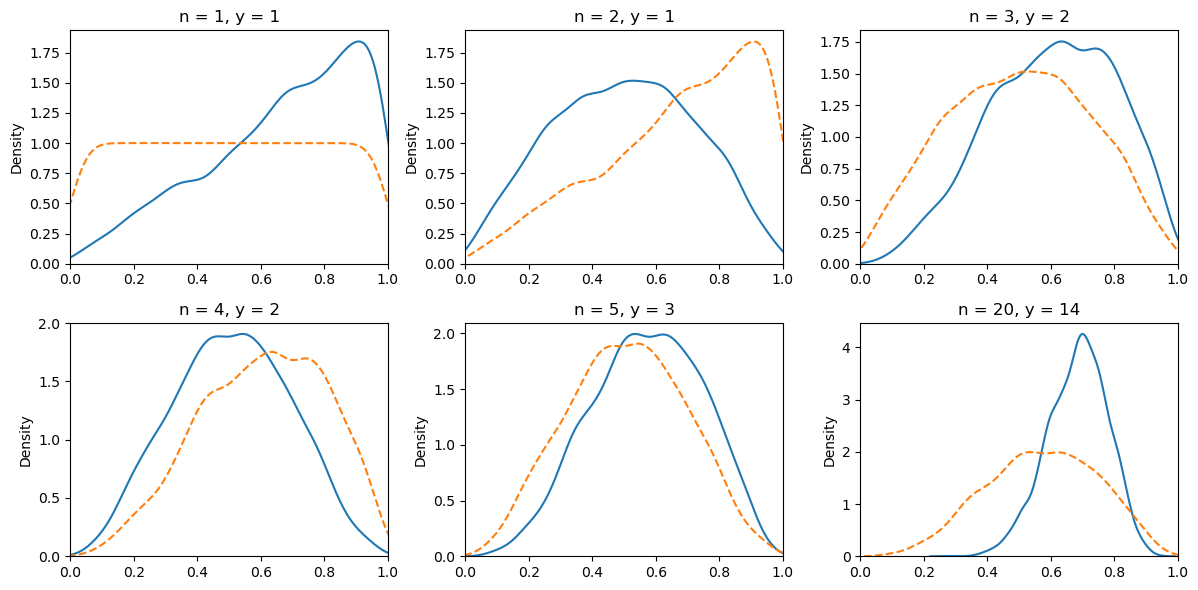

In [8]:
fig, axs = plt.subplots(2,3,figsize=(12,6))

for i in range(2):
    for j in range(3):
        sn.kdeplot(posterior_list[3*i+j],ax = axs[i,j])
        sn.kdeplot(posterior_list[3*i+j-1],ax = axs[i,j],linestyle='--')
        plt.gcf().get_axes()[3*i+j].set_xlim(0,1)
        axs[i,j].set_title('n = {}, y = {}'.format(n_values[3*i+j],y_values[3*i+j]))
fig.tight_layout();

Consider the top left figure. The prior (dashed line) is the uniform distribution (well, approximately; strictly speaking it should be a straight line). After throwing the coin once and observing heads ($y=1$) we can exclude $p=0$ and low values of $p$ are rather unlikely. Hence the solid curve falls relative to the prior for low values of $p$. But it lies above the prior for high values of $p$. We throw the coin again ($n=2$) and observe tails. Hence, we have one heads and one tails ($y=1$). This means we can also rule out $p=1$ and very high levels of $p$ are unlikely. Hence, compared to the previous posterior (dashed line in the second figure), lower values become more likely. Values around $p=0.5$ are now likely. We throw the coin again ($n=3$) and find heads ($y=2$), pushing the posterior to the right.

When throwing twenty times ($n=20$), we find 14 times head. The posterior starts to center around $p=0.7$. Note that the range of the y-axes increases as $n$ increases: we become more and more certain about the value of $p$ as the number of experiments increases.

The advantage of a posterior distribution is that it tells you what you expect it to tell you. To illustrate this, consider the posterior at $n=20$ which we plot now as cdf (cumulative distribution function):



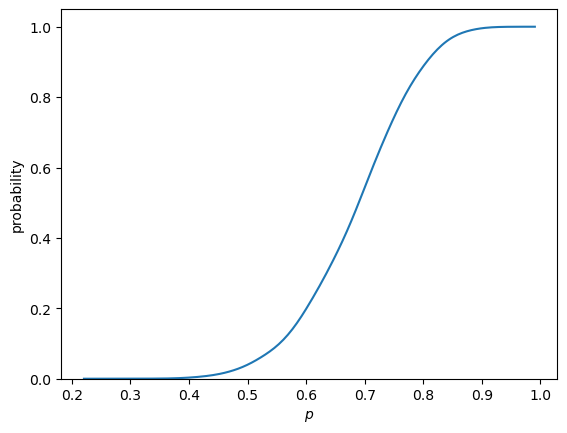

In [9]:
sn.kdeplot(posterior_list[-2],cumulative=True)
plt.ylabel('probability')
plt.xlabel('$p$');

This curve shows that with 40% probability it is the case that $p \leq 0.65$ (approximately). You cannot make this type of statement with standard (&ldquo;frequentist&rdquo;) econometrics. With a frequentist approach there is no uncertainty about (no probability distribution for) the parameter values. Parameter values are fixed (but you happen not to know them). So you make statements like &ldquo;suppose the slope equals 0, how likely am I to observe the data that I have&rdquo;. But you do not ask &ldquo;what is the probability that the slope equals 0&rdquo;?

To illustrate, many students make the following mistake when writing their MSc thesis: &ldquo;the confidence interval shows a range of values such that with 95% probability the parameter lies in this interval&rdquo;. This statement is incorrect. This is not what a confidence interval shows. But with a posterior distribution you can actually make this type of intuitive statements.

If you do not quite understand this yet, do not worry; we will get back to this point on the confidence interval.



#### Question: calculate the probability that $p>0.8$ after throwing the coin 20 times (with $y=14$).



[hint: use the variable `posterior_list`.]



In [24]:
np.sum((posterior_list[-2] > 0.8))/np.sum(posterior_list[-2])

0.1624754039250469

## Estimating a Bayesian model



In this section, we will do the Bayesian equivalent of an OLS regression. To understand how this works, we will generate our own data. Hence, we know what the true parameters are. Then we can see how the posteriors relate to the true parameter values. Then we will estimate a Bayesian model on the health data that we downloaded from Eurostat.



### Simulated data



First we use simulated data. We specify the stochastic relation between $x_1,x_2$ and $y$ and return the results in a dataframe. By now you should be familiar with this; i.e. you can easily read and understand what data is generated and you can also do this yourself. If this is not the case: practice! Create your own data and plot it to see that it looks the way you expected it.



In [3]:
def generating_data(a1 = 1, a2 = -1,b = 3, n=100):
    x1 = pm.Normal.dist(0,1).random(size=n)
    x2 = pm.Normal.dist(0,1).random(size=n)
    noise = pm.Normal.dist(0,1).random(size=n)
    y = b + a1 * x1 + a2 * x2 + noise 
    df = pd.DataFrame({'y':y, 'x1':x1, 'x2':x2})
    return df

df = generating_data()

#### Specifying a model



Here we go over the details of specifying a `pymc3` model. For more information on how to install `pymc3`, details of the syntax and examples of models, see the [pymc3 website](https://docs.pymc.io/).

There is also a [Datacamp course on pymc3](https://learn.datacamp.com/courses/bayesian-data-analysis-in-python) which will teach you Bayes and the pymc3 syntax.

We start a model with the line of code `with pm.Model() as model_simulated_data:`; `model_simulated_data` is the name of our model which you make up yourself. Note the indentation of the lines that follow: these all belong to this model. When we want to refer to this model later on, we start a line with `with model_simulated_data:` and indent all lines that follow and belong this statement. The `with` statement creates a so-called context.

The model that we specify says that `df.y` is normally distributed with expectation `mu` and standard deviation `sigma`. The expected value of $y$ for given values of $x_1,x_2$ is given by `mu = slope1*df.x1 + slope2*df.x2 + constant`. This is what the line with `obs` specifies. Further, since we actually observe $y$, we specify `observed = df.y` so that `pymc3` knows which observations it should try to match.

When specifying a variable in a `pymc3` model, you give the name two times. Once on the left hand side of the equal sign and once as a string after the opening bracket. It is an extremely good idea to make sure that these names are the same. You are not forced to do this; but will certainly run into problems if you choose different names. One name is used by the `pymc3` python code, the other by the Theano backbone of `pymc3`; but you do not need to worry about this, just make sure these names are the same.

The parameters of the model (`slope1,slope2,constant,sigma`) are themselves stochastic variables and we need to specify their prior distributions. Since this is an artificial example, it is hard to motivate the choice of priors in this context. So just take them as given here; below we come back to the issue of choosing priors. Here note the syntax of specifying the prior for e.g. `constant`: we write &ldquo;constant&rdquo; on the left hand side. On the right hand side we specify the distribution for the variable (here a normal distribution), repeat the name of the variable &rsquo;constant&rsquo; and specify the parameters of the distribution. Here $\mu=0, \sigma = 3$.

One thing to note is that the parameters `constant, slope1, slope2` can be either positive or negative and their priors (a normal distribution centered at 0) allow this. The standard deviation of $y$ has to be positive, hence we choose a half-normal distribution here such that the posterior cannot draw a negative value for `sigma` (which would result in an error).

The lines from `constant` to `obs` specify our Bayesian model: we specify what the dependent variable is (`observed = df.y`) and how it is distributed. Then for all the parameters in this model, we specify how they are distributed.

The line `trace = pm.sample()` starts sampling from the posterior distribution. Here we follow the default values of the method `sample`. Below we show how to choose different values for some variables. 

Next we generate the posterior predictive samples. These are our predictions for $y$. We show below how these can be used.

Although not necessary, it is usually convenient to bundle these samples using `az.from_pymc3()` so that you can give them a name `data_posterior_simulated_data` to refer to later on. You can also save these samples in this way in case they take rather long to generate.

When you run the code, you see the sampling happening which should take 10 seconds at most.



In [4]:
with pm.Model() as model_simulated_data:
    constant = pm.Normal('constant', 0, 3)
    slope1 = pm.Normal('slope1', 0, 2)
    slope2 = pm.Normal('slope2', 0, 2)
    sigma = pm.HalfNormal('sigma', 1)
    obs = pm.Normal('obs', mu = slope1*df.x1 + slope2*df.x2 + constant, sigma = sigma, observed = df.y)

    trace = pm.sample()

    
with model_simulated_data:
    ppc_simulated_data = pm.sample_posterior_predictive(trace, var_names=['obs'])

data_posterior_simulated_data = az.from_pymc3(
    trace,
    posterior_predictive = ppc_simulated_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope2, slope1, constant]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


We can visualize the model with its priors. This shows that `obs` has 100 observations and is normally distributed. In the model, `obs` is determined by the parameters `slope1, slope2, constant, sigma` and their prior distributions are provided as well.



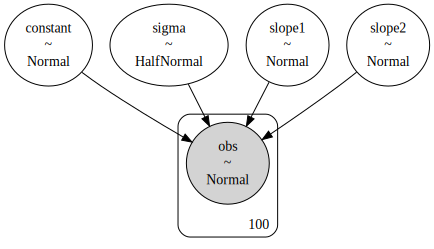

In [5]:
pm.model_to_graphviz(model_simulated_data)

#### Trace plot and posterior distribution



Now let&rsquo;s consider what the trace actually looks like and what we can learn from it. The trace samples from the posterior distribution of each of our four parameters. We plot the trace using `pm.plot_trace()` and discuss what we learn from it.

First, look at the distributions on the left. Each posterior distribution is &#x2013;more or less&#x2013; centered around the values we chose when generating the data. The `constant` is around 3, `slope1` around 1, `slope2` around -1 and the standard deviation on the noise term around 1. The distributions are not centered around the values that we chose, but with only 100 observations to estimate the model, this is actually quite good.



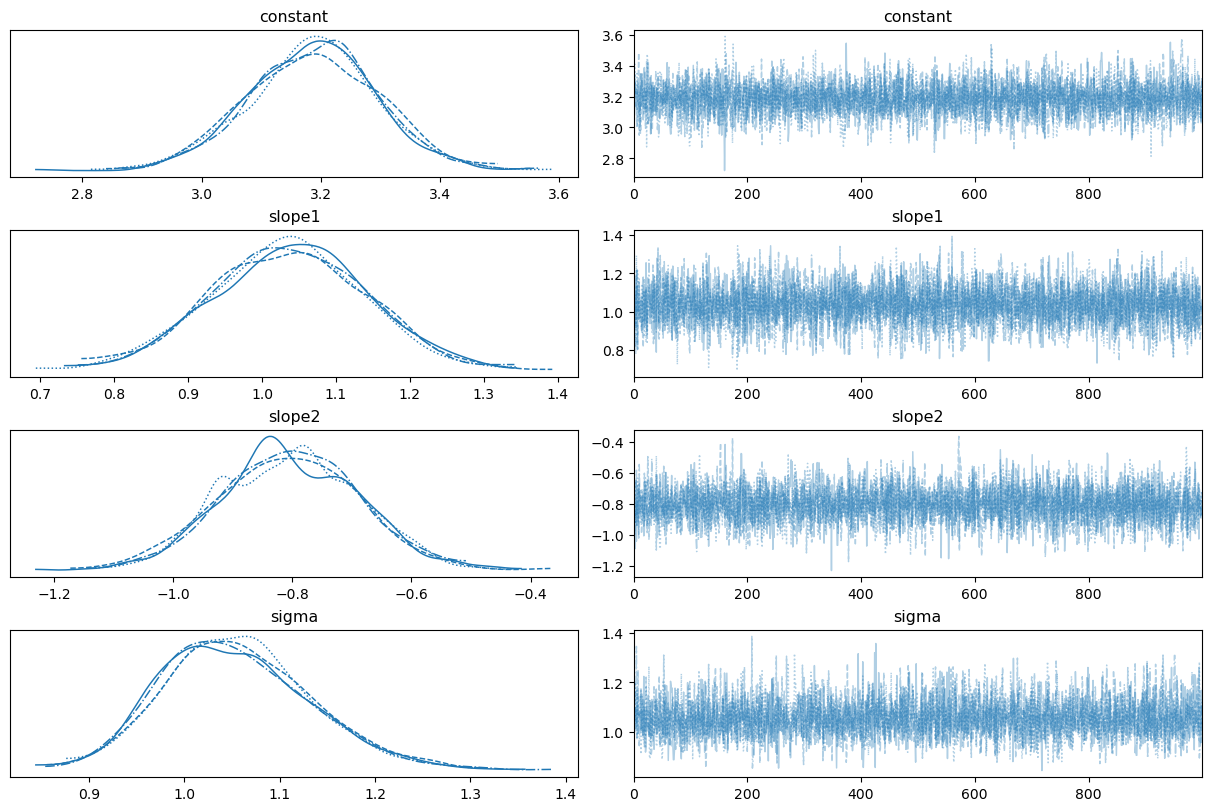

In [6]:
with model_simulated_data:
    pm.plot_trace(trace)

The trace plots on the right side are harder to interpret, but important in understanding whether the sampling process actually worked. It shows each point that is sampled (on the vertical axis) and these points are connected by a line. In my case, 4 chains of 500 samples are shown. Note that also here the posterior samples are more or less centered around parameter values that we set when generating the data.

There are three things to look for in the trace plots on the right. First, the plot should be stationary; for example, not trending upwards or downwards. In other words, the posterior mean value of the parameter is constant from beginning to end. Second, there should be good mixing which translates into the condensed zig-zagging of the trace. This implies that values are drawn across the whole domain of the posterior quickly after each other. In other words, the algorithm does not wander around for a while in one part of the posterior distribution and then &ldquo;spends time&rdquo; in another part of the distribution for a while. Finally, we want the different chains to cover the same regions. This is sometimes referred to as convergence. All three features are satisfied in the trace plots presented.

The algorithm used here to sample the posterior is call Markov Chain Monte Carlo. If you want to better understand how this algorithm works, you can watch [Richard McElreath&rsquo;s lecture on MCMC](https://www.youtube.com/watch?v=v-j0UmWf3Us).

To get some feel for how this works, I recommend that you play around with different parameter values to see how this is then picked up in the posterior distribution. Further, also change the number of observations ($n$) in the data to see the effect on the posterior. E.g. check that the choices for the expectation and standard deviation in the prior distributions hardly affect the posteriors if $n$ is big enough. This is intuitive: the more data we have, the less we need to rely on our initial beliefs (priors).



#### Summarizing the posterior distribution



We can also summarize the posterior in a table.



In [7]:
az.summary(data_posterior_simulated_data.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,3.188,0.108,2.977,3.382,0.001,0.001,5322.0,3031.0,1.0
slope1,1.036,0.104,0.831,1.221,0.001,0.001,6037.0,3367.0,1.0
slope2,-0.804,0.116,-1.023,-0.590,0.002,0.001,5350.0,2386.0,1.0
sigma,1.055,0.078,0.915,1.203,0.001,0.001,4415.0,3018.0,1.0


The important thing to observe here is that `r_hat` should be close to 1.0. If it is not, it is likely that there were problems with the MCMC algorithm. If `r_hat` equals 1.0, it is not a guarantee that the sampling was successful; you also have to check the trace plots.



#### Model fit



To get an idea of the model fit, we use the posterior predictive distribution. This is the distribution of $y$ for each observation in our data. The following figure shows both the model&rsquo;s prediction and the observed values as a function of both $x_1$ and $x_2$. In red are the observations in the data. The grey lines present the 95% interval of the model prediction. In a Bayesian analysis, the prediction is not a point, it is a distribution.

We use the `numpy` function `percentile` to get the percentiles at 2.5% and 97.5%. In between these we have 95% probability mass.

The vertical lines are drawn by `matplotlib`&rsquo;s function `vlines`.



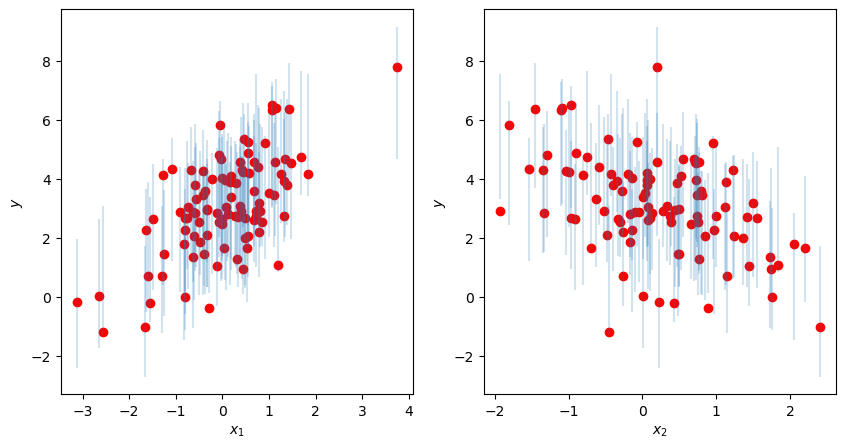

In [8]:
percentiles = np.percentile(ppc_simulated_data['obs'],[2.5,97.5],axis=[0]).T
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.vlines(df.x1,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax1.scatter(df.x1,df.y, color='r')
ax1.set(xlabel='$x_1$', ylabel='$y$');
ax2.vlines(df.x2,percentiles[:,0],percentiles[:,1],alpha=0.2)
ax2.scatter(df.x2,df.y, color='r')
ax2.set(xlabel='$x_2$', ylabel='$y$');

The figure shows that for most observations, the observed values lie in the 95% prediction interval of the model predictions. In this sense, the model does a reasonable job. Note that in the left side figure, we are not plotting $y$ as a function of $x_1$ (only). For the different values of $x_1$, the prediction takes the relevant value of $x_2$ into account as well. Hence, the prediction does not simply follow an upward sloping line.

Now we will apply this Bayesian technique to real data. This gives us an opportunity to be more precise about how to choose priors for the parameters that we estimate.



### Eurostat health data



For the model in this section, we use the data that we gathered from Eurostat. Hence we can load this data.



#### Load the data



In [1]:
df = pd.read_csv('./data/health_data.csv')
df.describe()

#+begin_example
       Unnamed: 0       year_x  Preventable mortality  Treatable mortality  \
count  448.000000   448.000000             446.000000           446.000000   
mean   223.500000  2014.000000             191.783520           110.963924   
std    129.470717     2.002236             132.025295            61.740504   
min      0.000000  2011.000000              45.910000            40.780000   
25%    111.750000  2012.000000              95.860000            70.230000   
50%    223.500000  2014.000000             164.055000            85.905000   
75%    335.250000  2016.000000             227.407500           126.267500   
max    447.000000  2017.000000             660.160000           333.310000   

       GDP per capita  year_y         y_QU1         y_QU2         y_QU3  \
count      444.000000   378.0    378.000000    378.000000    378.000000   
mean     32714.054054  2015.0   9830.103704  16740.196296  23225.081481   
std      26022.327013     0.0   6158.301385  10423.91354

As you can see, the counts for the different values differ. This implies that we have missing values for variables. We will deal with this below in two ways. First, the simple (but inefficient) way: delete all rows with missing values. This means we throw away a lot of information. Second, we use a Bayesian approach to deal with missing values.

To get an idea of our data, let&rsquo;s plot mortality against GDP per capita. We expect that richer countries (in terms of higher GDP per capita) feature lower mortality. However, we do not think that 10 euro higher income per capita will reduce mortality. The idea is that order of magnitude higher income will reduce mortality by an order of magnitude. To illustrate this, we plot mortality and GDP per capita on log-scales.

As an aside: we plot the figure here using `matplotlib`. In order to be able to distinguish the different countries we define our own color scheme. This leads to some fairly complicated code with things like `plt.get_cmap()` etc. Do not worry about this. Just make a &ldquo;mental note&rdquo; that the color scheme can be adapted in `matplotlib`. Since we have more than 20 countries, the end result is not great; it is still hard to distinguish some countries. As an illustration, we will use `altair` below to make an interactive plot. Then hovering over a point will tell you which country this is.



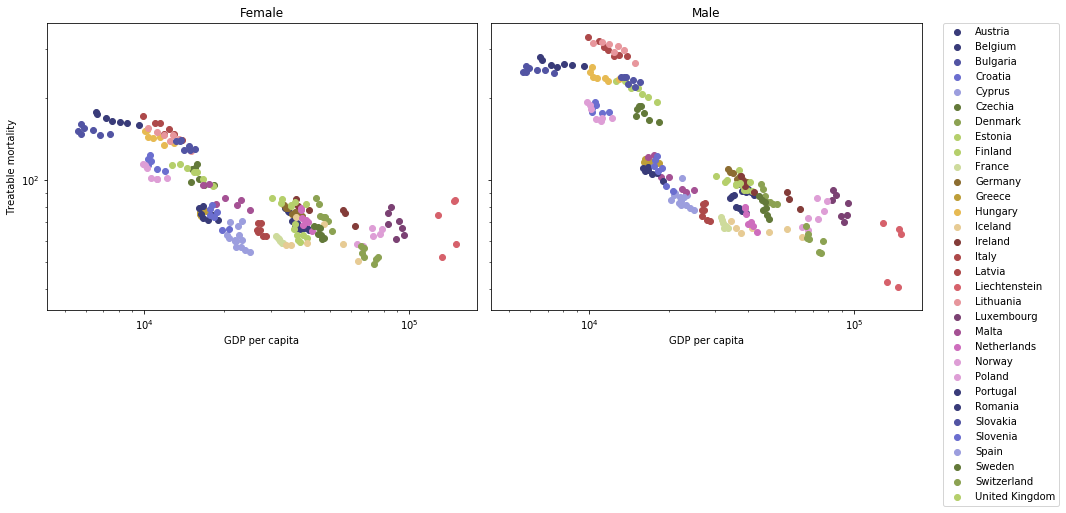

In [1]:
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm
import numpy as np
import statsmodels.api as sm

plt.style.use('seaborn-dark-palette')
NUM_COLORS = 24

cm = plt.get_cmap('tab20b') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)]))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,figsize=(13,5))


for country in df.country.unique():
    mask = (df.country == country)
    ax1.scatter(df[mask&(df.sex=='F')]['GDP per capita'], df[mask&(df.sex=='F')]['Treatable mortality'], label = country)
    ax2.scatter(df[mask&(df.sex=='M')]['GDP per capita'], df[mask&(df.sex=='M')]['Treatable mortality'], label = country)
    
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('GDP per capita')
ax2.set_xlabel('GDP per capita')
ax1.set_ylabel('Treatable mortality')
ax1.set_title('Female')
ax2.set_title('Male')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

This figure suggests a linear relation between log GDP per capita and log treatable mortality as a reasonable approximation. Further, female mortality tends to be lower than male mortality but this gender gap falls with income. We take these features into account in our model below.

If there is a log-log relation between mortality and income both between and within countries, we can see that income inequality (for given income per head) tends to increase mortality. This can be seen as follows.

Let $M$ denote mortality and $m=\ln(M)$ log mortality. Similarly, $Y$ denotes GDP per head and $y=\ln(Y)$. Then the relation between $m$ and $Y$ is of the form:

\begin{equation}
%\label{eq:2}
m = \beta_0 + \beta_1 \ln(Y)
\end{equation}

with $\beta_1 <0$. Hence, $m$ is convex in $Y$ and an increase in inequality (for given average $Y$) increases mortality:

\begin{equation}
%\label{eq:3}
\beta_0 + \beta_1 \ln(\phi Y_1 + (1-\phi) Y_2) < \beta_0 + \beta_1 (\phi \ln(Y_1) + (1-\phi) \ln(Y_2))
\end{equation}

for two income levels $Y_1 \neq Y_2$ and $\phi \in \langle 0,1 \rangle$. In words, the gain in health due to a higher income is smaller than the health loss due to a lower income (for given average income). One reason for this is decreasing returns to health expenditure. First, money is spent on the most effective treatments; as income increases further, money is spent on less effective treatments as well.

Based on this observation, we measure inequality in our data set as:

\begin{equation}
%\label{eq:19}
\text{inequality} = \ln\left(\sum_{i=1}^5 \phi_i Y_i \right) - \sum_{i=1}^5 \phi_i \ln(Y_i)
\end{equation}

where the fraction of people in income category $i$ denoted $\phi_i = 0.2$ as we have data on income quintiles. The higher this expression, the more unequal the income distribution in a country is.



#### Question: add the variable `inequality` to the dataframe using the definition above.



[hint: use the quintiles `y_QU1,...,y_QU5` in the data with $\phi_i = 0.2$ for $i=1,...,5$.]



### Missing values (the wrong way)



As observed above, we have missing values in the data. First, we will deal with these in a simple (but incorrect) way: simply delete rows from the dataframe that contain a missing value.

This is extremely inefficient since we lose information on the other values in the row that are not missing. Below we present a better way to deal with this. But this requires a bit more programming, so we will take this step by step.

We use `dropna()` to drop all rows that have missing values. The describe statement shows that all variables have the same number of observations now.



#### Question: define a new dataframe `df_small` by dropping all missing value from `df`.



[hint: look into the `pandas` method `dropna()`.]



#### Standardizing variables



Just as with neural networks, we can help the algorithm by standardizing our variables:



In [1]:
def standardize(x):
    return (x-x.mean())/x.std()
log_mortality = standardize(np.log(df_small['Treatable mortality']))
gdp = standardize(np.log(df_small['GDP per capita']))
inequality = standardize(df_small['inequality'])
high_bmi = standardize(df_small['high bmi'])
smoking = standardize(df_small['smoking'])
binge_drinking = standardize(df_small['binge drinking'])
gender = df_small['sex']=='F'

Just to be sure: note the order in which we do this: for GDP and mortality, we first take the log and then we standardize. If you do not understand why we do it this way, try for yourself: first standardize and then take the log.



#### Question: Complete the specification of the model



We model `log_mortality` as being normally distributed with expectation $\mu$ as specified below and standard deviation $\sigma$. 

Since log mortality is standardized, we model the prior for the `constant` as being normally distributed with 0 mean and standard deviation equal to 1. We specify one $\sigma_{prior}$ for all `b_` coefficients. The priors for these coefficients are normally distributed with mean zero and standard deviation equal to $\sigma_{prior}$.

To avoid over-fitting, we specify a small value for $\sigma_{prior}$. This is sometimes called a &ldquo;seat-belt prior&rdquo;. Low values for this standard deviation make sure that the model does not get &ldquo;too excited&rdquo; about the data. It is comparable to a (high) penalty term in a lasso or ridge regression. But here this is specified as a (conservative) prior. The more observations we have, the smaller the weight of this prior in the posterior. Hence, the model gets &ldquo;more easily excited&rdquo; if there are more data points, which is intuitive



In [1]:
with pm.Model() as normal:

      ## priors on coefficients
      constant = pm.Normal('constant', mu = 0.0, sd = 1.0)
      σ_prior = 0.1

      ### complete the priors

      ## model
      μ = constant + b_female * gender + b_gdp*gdp + b_inequality * inequality +  b_smoking * smoking + b_high_bmi * high_bmi + b_binge_drinking * binge_drinking + b_female_gdp * gdp * gender
      σ = pm.HalfNormal('σ', 1)

      mortality = pm.Normal('mortality', μ, σ, observed=log_mortality)
      trace_normal = pm.sample(2000, tune=1000)

#### Question: generate the posterior predictive distribution for the variable `mortality`. Use `az.from_pymc3()` to save the posterior predictive and the trace `trace_normal` into the variable `data_posterior_normal`.



#### Question: summarize the posterior distribution in a table; check the values for `r_hat`.



#### Check fit of the model



If you followed our naming suggestions above, you should be able to run the code below without errors to see the fit of the model. For most country/year/gender combinations the observation (dot) falls within the 95% prediction interval (vertical lines).



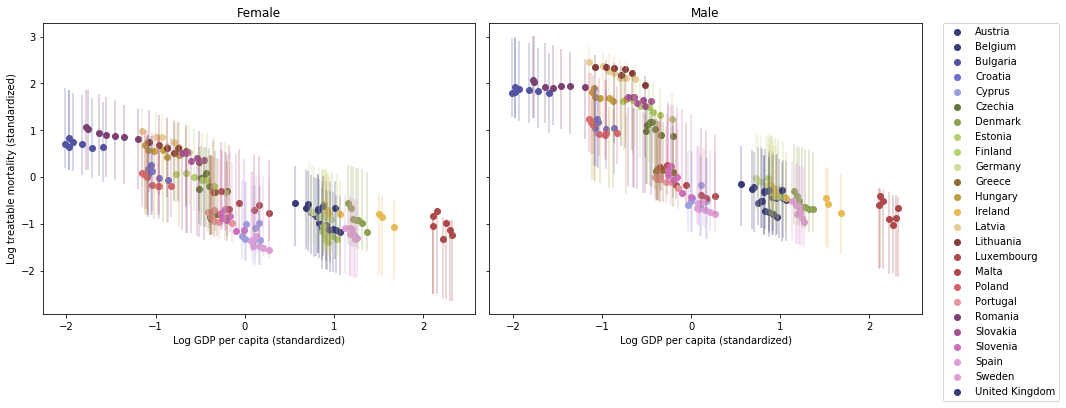

In [1]:
mask_female = (df_small.sex=='F')
mask_male = (df_small.sex=='M')
percentiles = np.percentile(data_posterior_normal.posterior_predictive.mortality,[2.5,97.5],axis=[0,1])

plt.style.use('seaborn-dark-palette')
NUM_COLORS = 24

cm = plt.get_cmap('tab20b') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=([scalarMap.to_rgba(i) for i in range(NUM_COLORS)]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True,figsize=(13,5))

for country in df_small.country.unique():
    mask = (df_small.country == country)
    ax1.vlines(gdp[mask_female&mask],percentiles[0,:][mask_female&mask],percentiles[1,:][mask_female&mask], color = next(ax1._get_lines.prop_cycler)['color'],alpha=0.3)
    ax1.scatter(gdp[mask&(df_small.sex=='F')], log_mortality[mask&(df_small.sex=='F')], label = country)
    ax2.vlines(gdp[mask_male&mask],percentiles[0,:][mask_male&mask],percentiles[1,:][mask_male&mask], color = next(ax2._get_lines.prop_cycler)['color'],alpha=0.3)
    ax2.scatter(gdp[mask&(df_small.sex=='M')], log_mortality[mask&(df_small.sex=='M')], label = country)
    
ax1.set_xlabel('Log GDP per capita (standardized)')
ax2.set_xlabel('Log GDP per capita (standardized)')
ax1.set_ylabel('Log treatable mortality (standardized)')
ax1.set_title('Female')
ax2.set_title('Male')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

### Interactive graph with altair



Just as an illustration of what you can do with python and [altair](https://altair-viz.github.io/), we will redo the figure with log GDP per head and log mortality and make it interactive.

If you want to know more about `altair`, there is a short [Datacamp introduction](https://www.datacamp.com/community/tutorials/altair-in-python).

You can open the file `gdp_mortality.html` in a web browser. You can add it to a website etc. You can use the slider to select a year, zoom in and out of the graph, hover over a point to see the country.



In [1]:
df.rename({'year_x':'year'},inplace=True,axis=1)

select_year = alt.selection_single(
    name='Select', fields=['year'], init={'year': 2011},
    bind=alt.binding_range(min=2011, max=2017, step=1)
)

df['log gdp'] = np.log(df['GDP per capita'])
df['log mortality'] = np.log(df['Treatable mortality'])
df['Gender'] = df['sex'].replace({'F':'Female','M':'Male'})

figure = alt.Chart(df).mark_point(filled=True,size=50).encode(
    alt.X('log gdp',title='GDP per captita(in logs)',scale=alt.Scale(domain=[9,12])),
    alt.Y('log mortality',title='Treatable mortality (in logs)',scale=alt.Scale(domain=[4,6])),
    color='country',
    column='Gender',
    tooltip=['country']
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).add_selection(select_year).transform_filter(select_year).interactive()

 

figure.save('./figures/gdp_mortality.html')

## Missing data (the right way)



Above we deleted all rows that feature a missing value. This is one extreme and it is not optimal. It means that we also lose values for variables that were observed in this row.

The other extreme is another common practice that is also not correct: interpolating the missing values. One method here is to substitute the mean of a variable for a missing value of this variable. The problem here is that your estimation method cannot distinguish real observed values from these interpolated values. Hence, these real and fake values have the same weight in the estimation which is not what we want. We have more faith in the real values than in the fake ones. Hence, the former should have a bigger effect on the estimates. 

The Bayesian way to deal with missing values is to model that they are drawn from a distribution. Since we work with standardized variables, we model that a missing value is drawn from a normal distribution with mean 0 and standard deviation equal to 1. When we sample our posterior, a missing value is sampled from this distribution; if there is an observed value for a variable, this value is used. This is an intuitive procedure: if we do not know the value of a variable (for a particular observation), we do know that it is drawn from this distribution. This uncertainty about the true value (due to different draws of values) is preserved in the posterior and everything that is derived from the posterior. Hence, the 95% interval for the predictive posterior will be wider due to the additional uncertainty of a missing value.

In order to use missing values in `pymc3`, we use so called masked `numpy` arrays (see [https://numpy.org/doc/stable/reference/maskedarray.html](https://numpy.org/doc/stable/reference/maskedarray.html)).

To get an idea what masked arrays do, consider the following example.



In [1]:
x = np.ma.array([1, 2, np.nan], mask=[0, 0, 1])
print("x in compressed/readable format: {}".format(x.compressed()))
print("x in raw format: ")
x

x in compressed/readable format: [1. 2.]
x in raw format: 
masked_array(data=[1.0, 2.0, --],
             mask=[False, False,  True],
       fill_value=1e+20)

The `mask` (`[False, False,  True]`) in the example above, indicates which values are missing (`True`) and which values are there (`False`). This additional information allows `pymc3` to figure out that there are missing values in the data which need to be treated differently.

Let&rsquo;s load the data.



In [1]:
df = pd.read_csv('./data/health_data.csv')
df.dropna(subset=['Treatable mortality'],inplace=True)
income_quantiles = ['y_QU1','y_QU2','y_QU3','y_QU4','y_QU5']
df['inequality']= np.log(df[income_quantiles].mean(axis=1))-(np.log(df[income_quantiles])).mean(axis=1)
df.drop(income_quantiles,axis=1,inplace=True)

def standardize(x):
    return (x-x.mean())/x.std()

log_mortality = standardize(np.log(df['Treatable mortality']))
gender = df['sex']=='F'

We define a new function to standardize our variables which can handle missing values. This function can work with masked arrays (`ma`).



In [1]:
def standardize_ma(x):
    x_ma = np.ma.masked_invalid(x)
    return (x_ma-x_ma.mean())/x_ma.std()

gdp = standardize_ma(np.log(df['GDP per capita']))
inequality = standardize_ma(df['inequality'])
high_bmi = standardize_ma(df['high bmi'])
smoking = standardize_ma(df['smoking'])
binge_drinking = standardize_ma(df['binge drinking'])

#### Question: complete the following model where we use the convention to indicate a variable with sampled values starting with uppercase.



That is, `gdp` indicates the vector with missing values and `Gdp` indicates the vector where `pymc3` replaces a missing value with one sampled from the distribution of gdp values. Hence, for the variables with missing values we also specify `observed`. If there is a value for `gdp`, `pymc3` uses this value, if it is missing, a value is sampled. Hence, `Gdp` has no missing values.

Complete the code for `ppc_normal_missing` and `data_posterior_normal_missing`.



In [1]:
with pm.Model() as normal_missing:

      ## priors on coefficients

      ## missing variables
      Gdp = pm.Normal('Gdp', mu = 0, sd = 1.0, observed = gdp)
      Smoking = pm.Normal('Smoking', mu = 0, sd = 1.0, observed = smoking)
      Binge_drinking = pm.Normal('Binge_drinking', mu = 0, sd = 1.0, observed = binge_drinking)
      High_bmi = pm.Normal('High_bmi', mu = 0, sd = 1.0, observed = high_bmi)
      Inequality = pm.Normal('Inequality', mu = 0, sd = 1.0, observed = inequality)

      ## model

      mortality = pm.Normal('mortality', μ, σ, observed=log_mortality)
      trace_normal_missing = pm.sample()
          
  with normal_missing:
      ppc_normal_missing = 

  data_posterior_normal_missing =

#### Question: summarize the posterior distribution with a table



Complete the following code block. In the summary, we are interested in the coefficients `variables_health`.



In [1]:
variables_health = ['b_female','b_gdp', 'b_female_gdp', 'b_inequality', 'b_smoking', 'b_high_bmi', 'b_binge_drinking']
az.summary(...,variables_health)

#### Question: provide the trace plots for `variables_health`.



Check that the trace plots satisfy the criteria discussed above.

In this section we have estimated the mortality model again but now we have correctly dealt with missing values for some variables.



## Bayesian time series



In economics we often work with time series data. There are a number of ways in which we can do this using Bayesian estimation. We start by looking at Gaussian Processes to model time series and the effect of the different kernels we can choose. Then we consider corona time series and use a simple model of an epidemic.

A Gaussian process can be used for any data where we expect correlation between the observations; time series are an obvious example, but the variable could also be age or distance. To illustrate, if you know average healthcare expenditure of a 50 year old male, you can predict average healthcare expenditures of 51 year old men.



### Gaussian Process



The idea of a Gaussian Process (GP) is that we draw from a multivariate normal distribution; that is, we do not draw one value but we draw a string of values (a vector) from the distribution. Hence, we need to specify the correlation between these different values; e.g. what is the correlation between the 1st and 5th value. This correlation is determined by the co-variance matrix of the multivariate distribution. The GP&rsquo;s kernel determines this co-variance matrix.

To illustrate the GP, let&rsquo;s create our own data. As you can see below, the time series feature a trend and a cyclical component. We use two different kernels for the GP to see how it picks up the cyclical effect and how this then affects the predictions of the model.



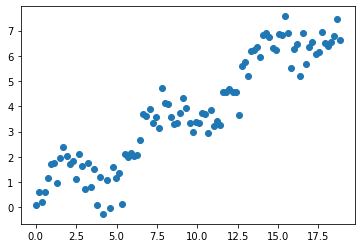

In [1]:
n = 100
x = np.linspace(0, 6*np.pi, n)
def time_series(x):
   return 0.4 * x + np.sin(x) 
y = time_series(x) + np.random.normal(0, 0.5, n)
plt.scatter(x, y);

#### GP with exponentiated quadratic kernel



A kernel specifies the correlation between two elements in the series that we have. In a time series this boils down to the correlation between the observation at time $t$ and time $t'$.

The exponentiated quadratic kernel is a fairly standard kernel for a Gaussian Process. Information on the choice of kernel can be found in the [kernel cookbook](http://www.cs.toronto.edu/~duvenaud/cookbook/). For kernels that are implemented in `pymc3`, see [the Covariance Functions page](https://docs.pymc.io/api/gp/cov.html).

The exact expression for the correlation between observations at $t$ and $t'$ is given by:

\begin{equation}
%\label{eq:5b}
k(t,t') = e^{-\frac{(t-t')^{2}}{2\ell^{2}}}
\end{equation}

In the code block we specify our prior for $\ell$ (`ls`) as $h$. The kernel is written as `pm.gp.cov.ExpQuad()` where we specify that our input variable (time) `X` is one dimensional (as a tensor). After specifying the kernel, the Gaussian Process itself is given by `gp`.

Here we use the gamma distribution for the prior on $h$. More information about gamma distributions can be found on [the pymc 3 website](https://docs.pymc.io/en/stable/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

The $x$ variable needs to be turned into a column vector $X$.

Finally, the last statement in this code block looks different from what we saw above with `obs = pm.Normal('obs', mu, sigma, observed = y)`. This is due to the way GP&rsquo;s are implemented in `pymc3`.



In [1]:
X = x.reshape(n,1)

with pm.Model() as timeseries_kernel:
    h = pm.Gamma('h', 3, 1.0)
    c = pm.gp.cov.ExpQuad(1, ls=h)
    gp = pm.gp.Marginal(cov_func=c)
    sigma = pm.HalfCauchy('sigma', 1.0)
    y_est = gp.marginal_likelihood('y_est', X=X, y=y, noise=sigma)

Sampling from GP&rsquo;s with MCMC &#x2013;as we did above&#x2013; is sometimes slow. Here we sample with ADVI. The [idea of ADVI](https://arxiv.org/abs/1603.00788) is to approximate the posterior distribution with a combination of well known distributions, like the normal distribution. Hence, the first step is an optimization problem to maximize the fit between the posterior and these approximating distributions.

We check whether the fitting went well by plotting the so called &ldquo;ELBO&rdquo; (evidence lower bound) plot. In this plot you look for a convergence towards the horizontal axis, as we can see below. This indicates that the algorithm converged.



Average Loss = 138.38: 100%|██████████| 20000/20000 [00:50<00:00, 400.00it/s]
Finished [100%]: Average Loss = 138.38

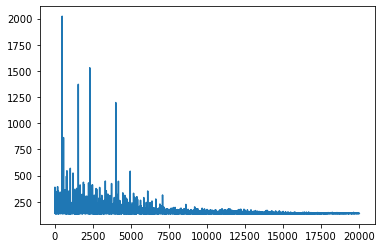

In [1]:
with timeseries_kernel:
    inference = pm.ADVI()
    approx = pm.fit(20000)

plt.plot(approx.hist);

Now we can generate samples from `approx` which we defined above as `approx = pm.fit()`.

We specify the range over which we want to predict `xp` and the number of samples that we want for the prediction, `n_samples`. Here we predict over the range `xp` for which we also have observations. That is, we do an in-sample prediction.



In [1]:
trace = approx.sample(draws=5000)

n_samples = 100
xp = np.c_[np.linspace(0, 6*np.pi, n_samples)]
with timeseries_kernel:
    gpc = gp.conditional('gpc', xp)
    ppc = pm.sample_posterior_predictive(trace, vars=[gpc], samples=n_samples)

100%|██████████| 100/100 [00:01<00:00, 51.22it/s]

We can plot this in-sample prediction (in grey) together with our observations (red dots). Note that our predictions are not points, but strings drawn from the multivariate normal distribution. That is, a sample is a (grey) line.



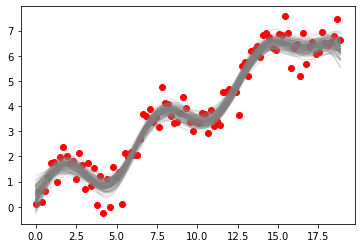

In [1]:
plt.plot(xp, ppc['gpc'].T, c='grey', alpha=0.2)
plt.scatter(x, y, c='red');

Finally, we can plot out-of-sample predictions. The interval `x_test` starts where the observations ended and plots a number of periods ahead. Although this kernel fits the observations reasonably well, it does not have the periodicity of the problem &ldquo;baked in&rdquo;. Therefore the out-of-sample predictions (in green) seem lower than what you perhaps would expect.

Hence, next we consider a kernel that can capture the periodicity explicitly.



100%|██████████| 100/100 [00:02<00:00, 48.60it/s]

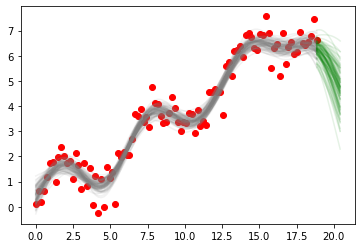

In [1]:
n_samples = 100
x_test = np.c_[np.linspace(6*np.pi, 6.5*np.pi, n_samples)]

with timeseries_kernel:
    gpc_test = gp.conditional('gpc_test', x_test)
    ppc_test = pm.sample_posterior_predictive(trace, vars=[gpc_test], samples=n_samples)


plt.plot(xp, ppc['gpc'].T, c='grey', alpha=0.1)
plt.plot(x_test, ppc_test['gpc_test'].T, c='green', alpha=0.1)
plt.scatter(x, y, c='red');

#### GP with periodic kernel



As mentioned, a kernel specifies the correlation between two elements. In a time series this boils down to the correlation between the observation at time $t$ and time $t'$. With a periodic kernel, the expression for this correlation uses something like $\sin(t-t')$. Hence, this correlation is high when $\sin$ equals 1. This gives the repetitive or cyclical part in the observations.

The exact expression for the correlation between observations at $t$ and $t'$ is given by:

\begin{equation}
\label{eq:5}
k(t,t') = e^{-\frac{ \sin^2(\pi |t-t' |\frac{1}{T})}{2\ell^{2}}}
\end{equation}

In the code block we specify our priors for $\ell$ (`ls`) and $T$ (`period`). The kernel is written as `pm.gp.cov.Periodic()` where we specify that our input variable (time) `X` is one dimensional (as a tensor). After specifying the kernel, the GP itself is given by `gp1`.

The kernel for the trend is simpler. It is given by

\begin{equation}
\label{eq:6}
k(t,t') = (t-c)(t'-c)
\end{equation}

In the code we specify a prior for $c$ and the kernel is given by `pm.gp.cov.Linear`.

Then we add the cyclical and linear components to get `gp`.

Again, the syntax for finalizing the model is different from above as `gp` now already contains our model of the distribution of $y$. Hence, we do not have something like `obs = pm.Normal(..., observed = y)` in this case.



In [1]:
X = x.reshape(n,1)

with pm.Model() as timeseries_periodic:
    # Cyclical component
    ls = pm.Gamma('ls', 1.0, 0.5)
    period = pm.Gamma('period',7,1)
    cov = pm.gp.cov.Periodic(input_dim=1, period = period, ls=ls)
    gp1 = pm.gp.Marginal(cov_func=cov)
    # Linear trend.
    c = pm.Normal(name='c', mu=0, sigma=1)
    gp2 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c))
    # adding the two components
    gp = gp1 + gp2
    sigma = pm.HalfCauchy('sigma', 0.5)
    y_est = gp.marginal_likelihood('y_est', X=X, y=y, noise=sigma)

We approximate the posterior using ADVI.



In [1]:
with timeseries_periodic:
    inference = pm.ADVI()
    approx = pm.fit()

Average Loss = 133.02: 100%|██████████| 10000/10000 [00:33<00:00, 295.73it/s]
Finished [100%]: Average Loss = 132.99

#### Question: show the ELBO plot



#### Question: sample the posterior from `approx` and generate the in-sample predictions



#### Question: plot the predictions together with the observed values



#### Question: generate and plot the out-of-sample predictions.



If you find time series interesting, you can find a more elaborate version of this analysis [here](https://juanitorduz.github.io/gp_ts_pymc3/).



#### Summary



With exponential quadratic kernel, the correlation over time is picked up, but according to these correlations it is likely that $y$ will fall before period 20. This is not the case with the trend and periodic kernels above. Hence it does matter which kernel you choose and it may be a good idea to split your data in a train and test set to see which kernel performs best.



### Covid data



Another way to model time series is to explicitly model the underlying process. An obvious example after 2020 is to model an epidemic. Let&rsquo;s look at some covid data.

As an aside: it may be a good idea to look at this warning about publishing the results of your model: [https://www.tableau.com/about/blog/2020/3/ten-considerations-you-create-another-chart-about-covid-19](https://www.tableau.com/about/blog/2020/3/ten-considerations-you-create-another-chart-about-covid-19)

We use the `covid19pandas` library to load the latest covid data directly into a dataframe.



In [1]:
global_df = cod.get_data_jhu()
global_df.head()

These data were obtained from Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19).
#+begin_example
        date   UID iso2 iso3  code3 Province/State Country/Region       Lat  \
0 2020-01-22   4.0   AF  AFG    4.0            NaN    Afghanistan  33.93911
1 2020-01-22   8.0   AL  ALB    8.0            NaN        Albania  41.15330
2 2020-01-22  12.0   DZ  DZA   12.0            NaN        Algeria  28.03390
3 2020-01-22  20.0   AD  AND   20.0            NaN        Andorra  42.50630
4 2020-01-22  24.0   AO  AGO   24.0            NaN         Angola -11.20270

        Long Combined_Key  Population  cases  deaths  recovered
0  67.709953  Afghanistan  38928341.0      0       0          0
1  20.168300      Albania   2877800.0      0       0          0
2   1.659600      Algeria  43851043.0      0       0          0
3   1.521800      Andorra     77265.0      0       0          0
4  17.873900       Angola  32866268.0      0       0          0
#+end_example

To get an overview of the countries and regions available in this dataset, use the following code:



In [1]:
global_df['Country/Region'].unique()

#+begin_example
array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'G

We will consider the Dutch corona data. But feel free to experiment by looking at different countries.



In [1]:
df_nl = cod.select_regions(
    data = global_df,
    region_col="Combined_Key",
    regions = "Netherlands")
df_nl.head()

#+begin_example
           date    UID iso2 iso3  code3 Province/State Country/Region  \
198  2020-01-22  528.0   NL  NLD  528.0            NaN    Netherlands
478  2020-01-23  528.0   NL  NLD  528.0            NaN    Netherlands
758  2020-01-24  528.0   NL  NLD  528.0            NaN    Netherlands
1038 2020-01-25  528.0   NL  NLD  528.0            NaN    Netherlands
1318 2020-01-26  528.0   NL  NLD  528.0            NaN    Netherlands

          Lat    Long Combined_Key  Population  cases  deaths  recovered
198   52.1326  5.2913  Netherlands  17134873.0      0       0          0
478   52.1326  5.2913  Netherlands  17134873.0      0       0          0
758   52.1326  5.2913  Netherlands  17134873.0      0       0          0
1038  52.1326  5.2913  Netherlands  17134873.0      0       0          0
1318  52.1326  5.2913  Netherlands  17134873.0      0       0          0
#+end_example

The column `cases` contains the accumulated number of cases recorded for the country. To create the column `new cases` we take the first difference using `.diff()`.



In [1]:
df_nl['new cases'] = df_nl.cases.diff()

#### Question: plot the `new cases`.



#### date selection



The idea here is to model exponential growth, which &#x2013;at the start&#x2013; is a feature of an epidemic. For this we need the time period starting from the situation where part of the population is already infected. Hence, we take &#x2013;rather arbitrarily&#x2013; as starting point 1-5-2020. We take as end point 1-11-2020 when policy measures were taken to reduce the spread of the virus.



#### Question: use pandas `.date.between()` method to select the dates 1/5/2020-1/11/2020 from `df_nl` and call this dataframe `df`.



[hint: check the pandas documentation for this method]

Then over this date range, plot `new cases` and `cases`.



#### Question: create a Bayesian model `exponential_model` by completing the following code block.



As case numbers become quite big, from a numerical point of view it is easier to work with log case numbers. Then we model `log_cases` as log-normal as the log normal distribution has most mass at low values. To see why this is relevant, run the model below with `pm.Normal('log_cases')`. Since, the number of cases equals `np.exp(log_cases)`, a high draw from this normal distribution leads to a huge value for number of cases. This then results in rather big prediction intervals in the posterior predictive distribution.

In the code block below, choose the priors for the parameters `a,b,eps`.



In [1]:
t = np.arange(0,len(df))
Log_cases = np.log(df.cases)

with pm.Model() as exponential_model:
    
    
    y = a * (1+b) ** t
    

    log_cases = pm.Lognormal('log_cases', mu = pm.math.log(y), sigma = eps, observed = Log_cases)
    prior_predictive = pm.sample_prior_predictive(samples=50)

Note that this model looks a bit different from the `pymc3` models above. In particular, the last line does not specify observed values. In contrast, it uses the `sample_prior_predictive()` method to generate predictions from the prior.

Predictions from the prior; what does that mean? Sometimes the Bayesian models you create depend on a number of parameters and it is hard to see what reasonable priors are for these parameters. What you can then do is to &ldquo;check&rdquo; the priors in the following way. Specify the model, including the priors and generate predictions, just from the priors (without confronting the model with the data yet).

Plot these predictions and see whether they look plausible. If you are modelling a count-variable, length, weight, GDP and your prior predictive shows negative values, you know the model is mis-specified. In our case, the figure above shows that number of cases varies roughly between 50k and 300k; hence the prior should cover numbers of comparable order of magnitude.

Play around with model specifications and choices for priors such that the prior predictions look somewhat plausible.



#### plot the predictive prior



Use the following code to plot your prior predictions and check whether your outcomes look reasonable/plausible.



| 0.0 | 500000.0 |

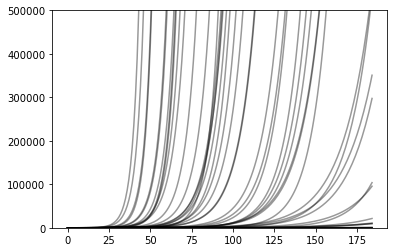

In [1]:
for a, b in zip(prior_predictive['a'],prior_predictive['b']):
    y = a*(1+b)**t
    plt.plot(t,y,c='k',alpha=0.4)

plt.ylim(0,500000)

#### Question: generate a trace from `exponential_model`; set `tune = 2000`.



-   create trace plots for `a,b,eps`
-   show the table summarizing the trace; what do you find for `r_hat`?



#### Question: generate the posterior predictive samples from `exponential_model`.



#### Plot `Cases` together with 2.5% and 97.5 percentiles of the posterior predictive distribution.



As you can see from the plot, observed number of cases falls within the predicted interval, except for the last days of the interval. At the end, case numbers increase faster than the model predicts.



#### Logistic model



Above we used an exponential model to capture the development of the number of Covid cases. One could argue that this cannot be a realistic model because the number of cases cannot grow exponentially for ever (although it may be a good approximation for a sub-interval). The idea is that at some point the whole population is infected; hence the cases then cannot increase further! At some point the number of infections has to level off.

Here we explain the logic of a logistic model and a new idea on how to find a prior for a variable using `pymc3`&rsquo;s `Deterministic` function. From then onward you can replicate the analysis we did above for the exponential model.

Assume the following relation between cases and time:

\begin{equation}
\label{eq:7}
y_t = \frac{c}{1 + a e^{-bt}}
\end{equation}

where $c$ denotes the number of cases that we will converge to as $t$ increases.

In this model, how do we set a prior for $a$? What does $a$ actually mean here? One way to think about this is to consider the number of cases that we start with:

\begin{equation}
\label{eq:8}
y_0 = \frac{c}{1+a}
\end{equation}

Hence, we can solve for $a$ as

\begin{equation}
\label{eq:9}
a = c/y_0 - 1
\end{equation}

We will not specify a prior for $a$ directly. Instead, we specify a prior for the number of cases at the start and a prior for the asymptotic number of cases. And then we specify $a$ using the equation above. In `pymc3` we do this with `pm.Deterministic()`, which is like, say, `pm.Normal()` except that no further stochastic elements are introduced. In other words, $a$ is given by the equation above in a deterministic &#x2013;non stochastic&#x2013; way. Of course, $a$ is a stochastic variable because it depends on the stochastic variables $c,y_0$.



In [1]:
with pm.Model() as logistic_model:
    # Define priors
    y0 = pm.Normal('y0', mu=4000, sigma=1000)
    b = pm.Normal('b', .1, .1)
    c = pm.Uniform('c',lower=1000,upper=10000000)

    a = pm.Deterministic('a', c/y0 - 1)

    # Logistic
    y = c / (1 + a * pm.math.exp(-b * t))

    eps = pm.HalfNormal('eps', 1)
    
    # Likelihood
    log_cases = pm.Lognormal('log_cases', pm.math.log(y), eps, observed=Log_cases)
    prior_predictive_2 = pm.sample_prior_predictive(samples=50)

#### Question: generate the prior predictive plot for $y_t$.



#### Question: generate the trace and posterior predictive samples.



-   summarize the posterior distributions for the parameters using a table
-   show the trace plot for the parameters
-   use the table and the plot to check that the MCMC sampling went fine



#### Question: Plot the observed time series and the 2.5 and 97.5 percentiles of the predictive posterior distribution



## Bayesian neural network



Above we have estimated Bayesian linear models and time series. The techniques for doing this are by now fairly standard. The modern implementations &#x2013;like `pymc3`&#x2013; of these techniques are new and exciting.

In this section, we get to what currently is the &ldquo;bleeding edge&rdquo; of datascience. This means that there are no simple implementations yet of this. The code below may look rather more technical than what you are used to. Don&rsquo;t worry about this! You do not need to understand all details.

This section follows [this blogpost](https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/). If you find this topic interesting, more details can be found there.

There are three main lessons that you should take from the analysis here. First, currently doing Bayesian neural networks is not yet simple, but this is likely to change in the next couple of years. `pymc3` is great for Bayesian analysis, but has no neural network implementation yet. `tensorflow` and `keras` make neural networks easy, but &#x2013;at the moment&#x2013; it is hard to do Bayesian analysis with them. Second, although not easy, it can be done as we show below. Third, by seeing an estimated Bayesian neural network, you will better understand the limitations of (standard) neural networks. In particular, neural networks are a bit of a black box and it is hard to understand the uncertainty surrounding the parameters of the network. For the simple example that we consider here we will be able to identify the values for the inputs where the network has a hard time predicting the value of the target.

We use a very simple dataset that we generate ourselves. Note that there is not a (linear) line that would separate the blue and red points. Hence, we need something more complicated to get correct predictions. We use [sklearn make moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) to generate this data.



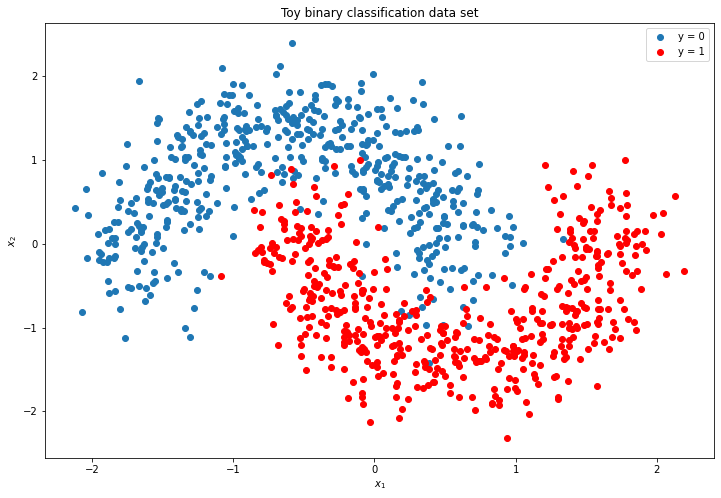

In [1]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = pm.floatX(X)
Y = pm.floatX(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='y = 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='y = 1')
ax.legend()
ax.set(xlabel='$x_{1}$', ylabel='$x_2$', title='Toy binary classification data set');

The goal is to estimate a neural network that can predict whether a point is blue (label 0) or red (label 1).

`np.mgrid` can be used to create a grid; in this case a two dimensional grid. The notation `1:10:2` indicates: start at 1 up to 10 (not inclusive) with step size 2. If a complex number is used (`j`), `1:10:4j` indicates that 4 points are chosen between start and finish points (end point inclusive)



In [1]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T

The function below constructs a neural network with 2 hidden layers and each layer has 5 neurons. The activation functions are the `tanh` and `sigmoid` functions which look as follows:



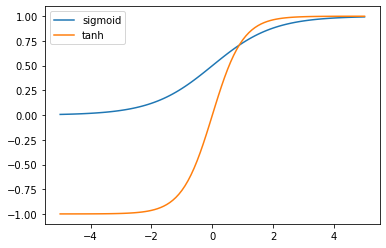

In [1]:
range_x = np.arange(-5,5.1,0.1)
plt.plot(range_x,pm.math.sigmoid(range_x).eval(),label='sigmoid')
plt.plot(range_x,np.tanh(range_x),label='tanh')
plt.legend();

When initializing the weights (randomly drawn from a standard normal distribution) for the 3 layers, `X.shape[1]` indicates the dimensions of the input variable (where the global variable $X$ was defined above), which is here two dimensional $(x_1,x_2)$ and hence the input dimension for the first layer equals 2; the output dimension equals 5: the number of nodes in the second layer. The second layer has 5 nodes and connects to the final layer with 5 nodes; hence we have 5 times 5 weights here. The final layer goes from 5 nodes to 1 output node: the probability that the target has label 1.

The initialization of the random weights is usually not necessary (they are used as `testval` in the priors in the model `neural_network`). They can help the sampling of the posterior in case a wrong starting point would really slow down the sampling.

The expressions for `weights_in_1, weights_1_2, weights_2_out` are priors for the weights associated with the nodes. We draw the priors from normal distributions with mean 0 and standard deviation 1.

`act_1, act_2, act_out` are the activation functions. For the first layer, the inputs are given by the matrix $X$ which is of the form $n*2$ where $n$ is the number of observations and 2 denotes the two inputs $(x_1,x_2)$. We multiply $X$ by $W_1$, the weights associated with the first layer which is a matrix of the form $(2,5)$ where we have 5 nodes in the first hidden layer. Then we apply the `tanh` activation function to this product: $\tanh(X W_1)$ and these values are the input for the second hidden layer. The second layer uses the same logic with the input is `act_1`.

The output layer multiplies the activations of the second hidden layer by the weights `weights_2_out` and applies the `sigmoid` activation to determine the probability that label 1 applies. As there are only 2 labels here, we do not need a softmax activation; sigmoid is fine here.

The variable $p$ is actually not necessary to solve the neural network. We create it here to be able to plot the probabilities of label 1 for all combinations of $(x_1,x_2)$ across the grid. It applies the activations of the first, second and output layer in one long line of code (the comments in the code will help you see what happens at each point).

The Bayesian network results in a Bernoulli distribution predicting whether the label equals 1 or 0. With probability `act_out` the value 1 is drawn from the Bernoulli distribution. (just as a reminder in case you do not know the Bernoulli distribution: $n$ draws from a Bernoulli distribution is modeled as a Binomial distribution)



In [1]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = pm.floatX(np.random.randn(X.shape[1], n_hidden))
    init_2 = pm.floatX(np.random.randn(n_hidden, n_hidden))
    init_out = pm.floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        
        ## specifying priors
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('weights_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('weights_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('weights_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        pm.Deterministic('p', 
            pm.math.sigmoid(         # begin activation output layer
            pm.math.dot(             # begin activation 2nd layer
                pm.math.tanh(
                    pm.math.dot(
                        pm.math.tanh(pm.math.dot(grid_2d, weights_in_1)), # activation 1st layer
                        weights_1_2) # end activation 2nd layer
                ),                 
                weights_2_out)       # end activation output layer
            )
        )
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches, which we do not use...
                          )
    return neural_network

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

`Theano` is the backend engine for `pymc3` taking care of tensor manipulation and differentiation; in this sense, it is comparable to `tensorflow`. The `theano.shared()` variable is comparable to `tf.Variable()` in `tensorflow` that we used before.

Since this Bayesian model is quite elaborate with lots of parameters, the MCMC algorithm becomes rather slow. Hence we use ADVI (Automatic Differentiation Variational Inference) here. The idea of ADVI is to approximate the posterior distribution with well known analytical distributions. The following code performs this approximation.



In [1]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

Average Loss = 131.69: 100%|██████████| 50000/50000 [00:26<00:00, 1894.29it/s]
Finished [100%]: Average Loss = 131.59

Once the posterior distribution has been approximated, we can draw samples from it:



In [1]:
trace = approx.sample(draws=5000)

To check whether the ADVI approximation was successful, we consider the so called &ldquo;ELBO&rdquo; (evidence lower bound) plot. We would like to see this plot to fall (rapidly, at the start). If this is not the case, the approximation is not very good and you cannot really trust the samples of the posterior.



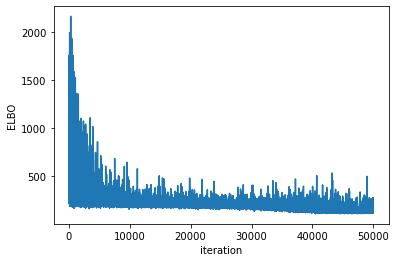

In [1]:
plt.plot(inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Now we can apply our model to the test data. If we need to predict a label for the test data, we predict label 1 if the average (across samples) probability for that point $x_1,x_2$ exceeds 0.5.



In [1]:
ann_input.set_value(X_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=400)

100%|██████████| 400/400 [00:02<00:00, 136.45it/s]

After all this code &#x2013;which admittedly is a lot more than specifying a keras neural network&#x2013; what is the use of a Bayesian neural network? One of the main gains is that we get a sense of the uncertainty surrounding the predictions of the neural network. We will illustrate this with a number of graphs.

The figure below plots the 0.5 contour line of $p$ for 50 posterior draws. Points below this contour line are classified as 1 (red), points above as 0 (blue). The different lines indicate where the network is uncertain about its classification. The wider the divergence between the lines, the more uncertain the network is.



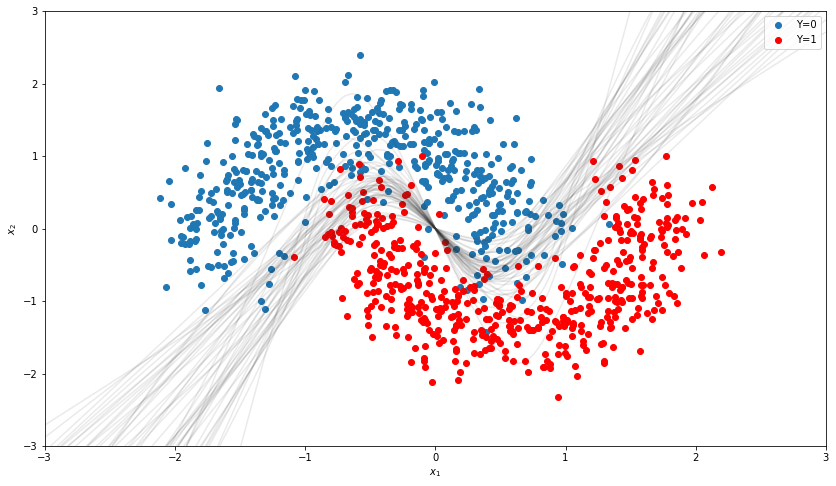

In [1]:
plt.figure(figsize=(14, 8))
for i in range(50):
    contour = plt.contour(grid[0], grid[1], trace['p'][i].reshape(100, 100), 
                         levels=[.5], cmap='Greys', vmin=0, vmax=0.6, alpha=.1)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend();

In [1]:
ann_input.set_value(grid_2d)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500)

100%|██████████| 500/500 [00:06<00:00, 77.80it/s]

The following figure uses colors to pinpoint the uncertainty that we have when classifying points. At the top left and bottom right of the figure we are very sure about the classification of points. But in the middle, following the white contour, we are quite uncertain; the classification probability hovers around 0.5. This is the uncertainty that a standard neural network will give you. In this case it is given by the `sigmoid`, if you have more than 2 labels, the `softmax` gives you this uncertainty: how sure are we that for a given input, a particular label applies.

What is different here is that the contours (iso-probability lines) are determined by taking the average over the samples that we have. With a standard neural network there is only one probability per input; here we have a &ldquo;family&rdquo; of probabilities for each combination of inputs.

Because we have a &ldquo;family&rdquo; of probabilities, we have an additional measure of uncertainty that a standard neural network does not have: the standard deviation of these probabilities.



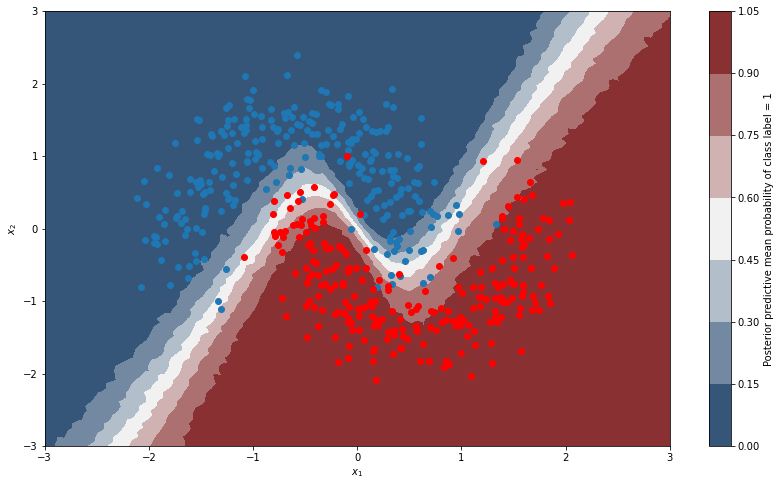

In [1]:
cmap = sn.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='$x_1$', ylabel='$x_2$');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');

The following plot shows the standard deviation of the posterior probabilities for each combination of inputs. At the top left and bottom right of the figure these standard deviations are small. They are not necessarily 0, but they are so small that there is no &ldquo;flipping&rdquo; of the probability above and below 0.5 which would change our prediction of the target.

In the middle the standard deviation is high (close to 0.5) which means that our prediction tends to flip for different posterior samples. This type of uncertainty information is **not** provided by a standard neural network.



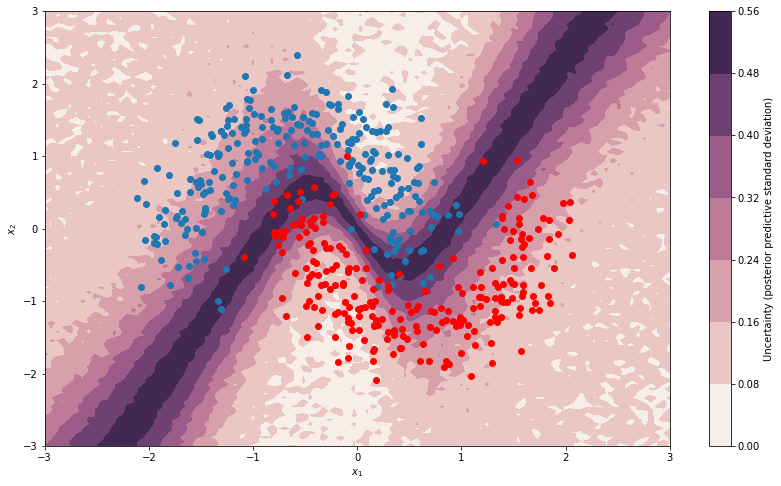

In [1]:
cmap = sn.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='$x_1$', ylabel='$x_2$');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

So what can we do with this extra information about uncertainty. First, it tells us which predictions are quite robust and hence we can readily trust them. Think of the case where you need to undergo a life-threatening operation in hospital (blue point) or where it is better to do nothing (red point). Or a situation where you have to invest money in some business project that can be profitable (blue point) or loss making (red point). Then a standard neural network will simply tell you &ldquo;blue&rdquo; (go for it) or &ldquo;red&rdquo; (better not). But given that this classification is more certain for some inputs than for others, you would like to know the uncertainty surrounding the neural network&rsquo;s recommendation.

Second, the uncertainty suggests for which inputs extra information could be beneficial. If the cases where you need a recommendation are all in low standard deviation areas, there is no real need to dig deeper for further information. But if your cases all feature high uncertainty, you may want to get more information before you decide. A standard neural network does not provide this extra information.

Finally, in the simple example above, uncertainty about $p$ is closely connected to values for $p$ around 0.5; but this need not be the case for every network. In more complicated settings it can happen that a particular neural network is quite certain ($p$ around 0.1), but a different neural network (i.e. different weights) features for the same input a value for $p$ equal to 0.9. Solving a standard neural network will only give you one probability (either 0.1 or 0.9) and you would assume that the network is quite sure about its predictions. The Bayesian neural network will actually show you this rather big variation in $p$ across samples of the posterior.



## What is a confidence interval?



As we have mentioned a couple of times before, students tend to make the following mistake in their MSc thesis; they write: &ldquo;the 95% confidence interval contains the true value of the parameter with 95% probability&rdquo;. It is a subtle issue, but this statement is actually incorrect. Most of the econometrics you have probably seen is in the tradition of &ldquo;frequentism&rdquo;. And a confidence interval is part of this frequentist approach. Below, we compare the frequentist confidence interval with the Bayesian analogue referred to as credible or compatibility interval.

In a sense, you probably know already why the statement is incorrect: in frequentism there is no uncertainty about the parameter. That parameter is fixed; but we do not know what it is. Statements in frequentism take the form: assume that the parameter equals, say, zero, how likely is it that we observe this data, $p(\text{data}|\mu)$. Hence, the uncertainty is about the data, not about the underlying parameter. In other words, the randomness is about the sample that we draw from the population not the underlying parameters.

This we can model to simulate confidence intervals. We take the simplest example: We draw a sample $x_1,...,x_n$ from a normal distribution with (unknown) mean $\mu$ and (known) standard deviation $\sigma=1$. We calculate the sample mean $m = \sum x_i/n$ and the 95% confidence interval $[m - 2 \sigma_m, m + 2 \sigma_m]$ where $\sigma_m = \sigma/\sqrt(n)$ denotes the standard deviation of the sample mean $m$.



In [1]:
def interval_95(X,σ):
    """X should be of the form: number of repetitions (in rows) times sample (in columns)"""
    mean = X.mean(axis=1) # for each row (repetition) take the mean across the sample
    σ_m = σ/np.sqrt(X.shape[1])
    return np.array([mean - 2 * σ_m, mean + 2 * σ_m])

μ = 100
σ = 10

#### Question: use a sample size of 9 and 100,000 repetitions, create the matrix $X$ as described in the function `interval_95()` above



-   define the Boolean vector checking that $\mu$ lies in the 95% interval as defined by `interval_95()`
-   calculate in which percentage of cases $\mu$ lies in this 95% interval

Note that $\mu$ does not vary when we are doing these simulations; it stays fixed at $\mu=100$. There is no randomness with respect to $\mu$. But we do draw different samples and hence find different sample means. The different sample means generate different confidence intervals. We are calculating how often these (stochastic) confidence intervals actually contain $\mu$.



#### Credible interval



We have used so called 95% Bayesian credible intervals above; sometimes referred to as compatibility interval. E.g. with vertical bars in the predictive plots. These intervals are &ldquo;what&rsquo;s on the tin&rdquo;: there is a 95% probability that the true parameter lies in this interval. Hence, a Bayesian credible interval is easier to interpret. But it is slightly more complicated to simulate (which you would normally not do anyway).

In the frequentist approach the parameter $\mu$ is fixed and the randomness comes from the sample that we draw. In a Bayesian framework there is uncertainty about $\mu$ (we do not know what it is) but we are certain about our data: we have observed our data, the data do not change. Hence, we are interested in $P(\mu | \text{data})$. In the simulation that we do, conditioning on the data is not quite trivial.

We have observed `data` and we have calculated the 95% (Bayesian) interval for `data`. Now we generate different values for the parameter $\mu$ and for each $\mu$ we generate a sample. Since we condition on `data` in this case, our new sample should be equal (or at least close) to `data`. Here we interpret this as saying that sample average should be close to the sample average of `data`. How close these averages should be is determined by `precision`.

For samples that we have drawn that are close to `data`, how often does $\mu$ lie in the 95% interval? If you run the code below, you see that this is approximately 95%.



In [1]:
mu = np.random.uniform(80,120,size = (repetions,1))
data = (np.random.normal(100,σ,size = (1,n_sample)))
interval = interval_95(data,σ)

m = data.mean()
Y = np.random.normal(mu,σ,size = (repetions,n_sample))
precision = 0.5
mask = np.abs(Y.mean(axis=1)-m)< precision
μ = mu[mask]

test = (interval[0] < μ) & (μ < interval[1])
print(np.sum(test)/test.shape[0])

0.95

#### Question: interpretation of the code



-   where do you see that we also use $\mu=100$ as we did in the code above for the confidence interval?
-   how many 95% intervals do we calculate here?
-   what is the role of `mask` in the code above?
-   in the last statement: why do we divide by `test.shape[0]` and not simply by `repetitions`?



### Summary



The goal of this section is to use simulated data to explain why the statement &ldquo;the 95% confidence interval contains the true value of the parameter with 95% probability&rdquo; is incorrect. With a frequentist approach, the correct statement &ldquo;if you form confidence intervals, *this procedure* will generate an interval that contains the true parameter value in 95% of the times&rdquo;. The probability refers to the procedure not to the underlying parameter.

In a Bayesian context, the statement is correct: such an interval contains the true value of the parameter with 95% probability.

The simulations (hopefully) make clear what the different conditions (condition on parameter vs. condition on data) imply. We do not argue that there is anything &ldquo;wrong&rdquo; with a confidence interval. Just make sure you interpret a confidence interval correctly if you use one.

[This blog](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/) (on which the simulations above are based) goes one step further and gives an example where the frequentist approach and its confidence interval are actually misleading. So if you are interested you can look at this blog for more analyses along these lines.

